# INTRODUCTION



Topic modeling is an unsupervised machine learning task which aims to discover the abstract "topics" that occur in a collection of documents, and consequently to the classification of the documents themselves (similar to clustering on numeric data, which finds some natural groups of items).
It can scan the corpus and identify the phrase patterns and words inside it, and create a collection of the word groups and related **expressions that rightly characterize the document sets**. Topic modeling has various applications, including document clustering, information retrieval, content recommendation, and exploratory analysis of large text corpora.

In practice, it is the process of **logically choosing words** that represent a specific subject from inside the document. In this work, one of the most commonly used algorithms for topic modeling will be studied: Latent Dirichlet Allocation.

## LDA



LDA, short for Latent Dirichlet Allocation, is a **statistical** method - born in the context of population genetics- that treats documents as a **mixture** of various topics, and each topic is itself a mixture of words. First, let's break down the word and understand what does LDA mean. *Latent* means hidden, something that is yet to be found. *Dirichlet* indicates that the model assumes that the topics in the documents and the words in those topics follow a Dirichlet distribution. *Allocation* means to giving something, which in this case are topics.
LDA doesn't give you a single label for each document, but rather the **probability of each document belonging to multiple topics**. This allows for a more nuanced understanding, as a single document might discuss different topics.

LDA assumes the following generative process, for each document
$m ∈ {1, . . . , M}$:
1. The document-topic distribution $θ_m$ is chosen from a Dirichlet distribution with parameter $α$;
2. for each of the $N_m$ words in document $m$:
 -  the topic assignment $z_{m,n}$ for the n-th word is chosen from $θ_m$,
 - the n-th word $w_{m,n}$ is chosen from the Dirichlet distribution controlled by $β$.

<img src="https://drive.google.com/uc?export=view&id=1FqN0osFwhtD8wVsB1WxWAnK5eZBez9sR" width="800" height="300">


## Dirichlet distribution

The Dirichlet distribution is a multivariate distribution. We can denote the parameters of the Dirichlet as a vector of size K of the form ~$\frac{1}{B(a)}\cdot ∏_ix_ia^{i−1}$ where $a$ is the vector of size $K$ of the parameters, and $∑x_i=1$.

LDA uses some constructs like:

* a document can have multiple topics (because of this multiplicity, we need the Dirichlet distribution); and there is a Dirichlet distribution which models this relation.
* words can also belong to multiple topics, when you consider them outside of a document; so here we need another Dirichlet to model this.

Now, in Bayesian inference we use the Bayes rule to infer the posterior probability. For simplicity, let's say we have data $x$
and we have a model for this data governed by some parameters $θ$. In order to infer values for this parameters, we will infer the posterior probability of these parameters using Bayes' rule with:

$p(θ|x)=\frac{p(x|θ)\,p(θ|α)}{p(x|α)}⟺\text{posterior probability}=\frac{\text{likelihood}×\text{prior probability}}{\text{marginal likelihood}}$

Note that here comes an $α$. This is our initial belief about this distribution, and is the parameter of the prior distribution. Usually this is chosen in such a way that will have a conjugate prior (so the distribution of the posterior is the same with the distribution of the prior) and often to encode some knowledge (if we have one) or to have maximum entropy (if we know nothing).

So, in LDA, both topic distributions, over documents and over words have their correspondent priors, which are denoted usually with *alpha* and *beta*.

# Priors
Now, about choosing priors, what happens in the Dirichlet probability distribution function when tweaking the priors?
* If all the $α_k$ have values lower than unit the maximum is found at corners
* If all values $α_k$ are the same and greater than 1 the maximum will be found in the center.
* It is easy to see that if values for $α_k$ are not equal the symmetry is broken and the maximum will be found near bigger values.

Additional, that values for priors parameters produce smooth pdfs of the distribution as the values of the parameters are near 1. **So if you have great confidence that something is clearly distributed in a way you know**, with a high degree of confidence, **then values far from 1** in absolute value **are to be used** (we will do use this in the *result section*!), if you do not have such kind of knowledge than values near 1 would be encode this lack of knowledge. It is easy to see why 1 plays such a role in Dirichlet distribution from the formula of the distribution itself.ù

Eventually, **prior encode prior-knowledge** in the same way we might think that prior encode some prior seen data. This data was not seen by the algorithm itself, it was seen by us, we learned something, and so we can model prior according to that. So in the prior parameters (hyperparameters) we encode also how big these data we apriori saw. So the bigger the apriori dataset, the bigger is the confidence, the sharper the surface near maximum value.

---


In [ ]:
show_simplex() # An interactive view of a simplex, with tunable component of the prior! We will use it latter in the discussion.

In the following, an overview of the training is given. After that, we carefully explain every part of it.



# TRAINING OVERVIEW

In [ ]:
import time
start_time = time.time()

import warnings
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from google.colab import drive
drive.mount('/content/drive')

!pip install pyLDAvis "pandas==1.5.3"
import pyLDAvis
import pyLDAvis.gensim

import os
import pickle

#import csv
import pandas as pd
import numpy as np
import spacy

import gensim
import gensim.corpora as corpora
import gensim.utils as simple_preprocess
from gensim.models import CoherenceModel, phrases, TfidfModel

!pip install openpyxl --upgrade

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
custom_stopwords = {'genarall', 'decideie', 'pargrraph', 'legslater', 'hname', 'prresident', 'eflaw',
                    'concisse', 'confse', 'segegater', 'politial', 'congerssional', 'http', 'https',
                    'amp', 'com','ahe','punch', 'voae', 'elecaion', 'ahere', 'elecaor', 'elecaoral',
                    'metione', 'preffer', 'ahaa', 'oua', 'saaae', 'presidena', 'candidaae', 'aime',
                    'satar', 'someno', 'decisson', 'canot', 'inncodent', 'senat', 'aeoale', 'acount',
                    'telework', 'vitaman', 'modelt', 'cashstrappe', 'devlopment', 'modelt', 'devlopment',
                    'yespollution', 'anual', 'nocar', 'posession', 'aiout', 'aisolutly', 'columiia',
                    'confineded', 'dai', 'descriie', 'emence', 'evennumiere'}
stopwords = list(stopwords.words('english')) + list(custom_stopwords)

path="/content/drive/MyDrive/NLP"
dataset_path = path + "/AI_Human.csv"
dataset_rows = 50000
use_lemmatization = True
maintain_stopwords = False
make_trigrams = True
lower_threshold = 0.01
num_topic = 50
alpha_value = 'auto'
epochs = 60
learning_decay = .7

#   Part of speech (POS) tags for lemmatization
complete_pos = ["ADJ", "ADP", "ADV", "AUX", "CONJ", "CCONJ", "DET", "INTJ", "NOUN", "NUM", "PART", "PRON", "PROPN", "SCONJ", "VERB"]
pruned_pos=['NOUN', 'ADJ', 'VERB', 'ADV']

def lemmatization(texts, maintain_stop):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) #for a fast sentence segmentation without dependency parses, disable the parser. ner isn't useful for this application
    nlp.Defaults.stop_words |= custom_stopwords # Syntactic sugar to obtain the union of two sets

    if maintain_stop:
        allowed_postags = complete_pos  # Light lemmatization: more freedom in parts of speech
    else:
        allowed_postags = pruned_pos    # Tight lemmatization: only nouns, adjectives, verbs, and adverbs are retained

    texts_out = []          # All the documents with lemmatized words will be here
    for text in texts:      # Iterate over doc in the corpus
        doc = nlp(text)     # Text analysis through the Spacy pipeline
        new_text = []
        for token in doc:   # Iterate over words in the doc
            if (token.pos_ in allowed_postags) and (maintain_stop or not token.is_stop): #si mantengono parole del tipo corretto, e si rimuovono le stopwords se richiesto
                new_text.append(token.lemma_)  # Lemma extraction
        lemmatized_doc = " ".join(new_text)  # Documents with all the words separated with a space. List to string
        texts_out.append(lemmatized_doc)
    return texts_out

def stemming(texts, maintain_stop):
    stemmer = SnowballStemmer(language='english') # Initialize SnowballStemmer

    texts_out = []
    for text in texts:              # Iterate over doc in the corpus
        words = word_tokenize(text) # Tokenize the document into words
        stemmed_words = [stemmer.stem(word) for word in words if (maintain_stop or (word not in stopwords))]
        stemmed_document = ' '.join(stemmed_words) # Documents with all the words separated with a space. List to string
        texts_out.append(stemmed_document)
    return texts_out

def normalization(texts):
    normalized = []     # All the documents with normalized words will be here
    for text in texts:  # Iterate over doc in the corpus
        x = gensim.utils.simple_preprocess(text, deacc=True)#, min_len=3)  # Tokenization, accent elimination, min length,
        normalized.append(x)
    return normalized

#   DATASET IMPORT
df = pd.read_csv(dataset_path, nrows = dataset_rows)
data = (list(df.text)) # Extraction of relevant data: only the first column, named 'text'


if use_lemmatization: # Lemmatization or stemming alternatives
    lemmatized_or_stemmed_texts = lemmatization(data, maintain_stopwords)
else:
    lemmatized_or_stemmed_texts = stemming(data, maintain_stopwords)

data_words = normalization(lemmatized_or_stemmed_texts)

#   BIGRAMS AND TRIGRAMS:
if make_trigrams:
    # Automatically detect common phrases – aka multi-word expressions, word n-gram collocations – from a stream of sentences
    # Initializing the classes
    bigram_phrases = gensim.models.Phrases(data_words, connector_words=phrases.ENGLISH_CONNECTOR_WORDS)
    trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], connector_words=phrases.ENGLISH_CONNECTOR_WORDS)

    bigram = phrases.Phraser(bigram_phrases)    # Alias of gensim.models.phrases.FrozenPhrases:
    trigram = phrases.Phraser(trigram_phrases)  # cut down memory consumption of Phrases

    data_bigrams = [bigram[doc] for doc in data_words] # Unifying words in bigrams and trigrams
    data_bigrams_trigrams = [trigram[bigram[doc]] for doc in data_bigrams]
    documents = data_bigrams_trigrams
else:
    documents = data_words

#   ID2WORD DICTIONARY CREATION + TF-IDF REMOVAL
id2word_diction = corpora.Dictionary(documents)
dictionary_size = len(id2word_diction)
print('Total Vocabulary Size:', dictionary_size)

corpus_bow = [id2word_diction.doc2bow(doc) for doc in documents] # Iterating over all docs, this makes the Corpus as a BOW, before TFIDF

tfidf = TfidfModel(corpus_bow, id2word=id2word_diction) # this class realize the transformation between word-document co-occurrence matrix (int) into a locally/globally weighted TF-IDF matrix (positive floats)

dropped_words = []
for i in range(0, len(corpus_bow)):
    low_value_words = []    # To store word IDs with low TF-IDF values
    bow = corpus_bow[i]     # Bag-of-Words representation of the current document
    #tfidf_ids = [id for id, value in tfidf[bow]]  #estrae ID delle parole nel corpus_bow
    #bow_ids = [id for id, value in bow]  #estrae ID delle parole nel DOC
    low_value_words = [id for id, value in tfidf[bow] if value < lower_threshold]  #parole sottosoglia

    dropped_here = [] # Dropped words of this document, created only for exploratives purpose
    for item in low_value_words:
        dropped_here.append(id2word_diction[item])  # id2word_diction maps an (item) ID into a natural language word
    dropped_words.append(dropped_here)  # All dropped words collection, doc by doc

    new_bow = [b for b in bow if b[0] not in low_value_words] # b[0] is the word ID
    #   maintain only the words (= ID-FREQ pair) with ID not in low_value_words

    #reassign
    corpus_bow[i] = new_bow

#   MODEL
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus_bow,
                                            id2word = id2word_diction,
                                            alpha = alpha_value,
                                            num_topics = num_topic,
                                            passes = epochs,
                                            decay = learning_decay)

#   EXTRACTING RESULTS
coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=documents,
                                     dictionary=id2word_diction,
                                     coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()

term_topic_distrib = lda_model.show_topics(num_topics=-1, num_words=10, log=False, formatted=False)
term_topic_df = pd.DataFrame([[f'{term}'+"  "+f'{format(frequency, ".3f")}' for term, frequency in topic[1]] for topic in term_topic_distrib], columns = ['Term'+str(i) for i in range(10)], index=['Topic '+str(t) for t in range(0, num_topic)]).T

doctopic_list=[lda_model.get_document_topics(item) for item in corpus_bow] #lista dove gli elementi sono liste (una per doc) con coppie (topic, rilevanza)
doc_topic_df = pd.DataFrame(0, index=np.arange(dataset_rows), columns=["Topic "+str(i) for i in range(num_topic)]) #inizializzo a zero

for row, topic_items in enumerate(doctopic_list):
    for couple in topic_items:
        doc_topic_df.iloc[row, couple[0]] = couple[1] # couple[0] is the topic name (i.e. columns of the new dataframes) while couple[1] contains the relevance of that topic
running_time=int(time.time() - start_time)

#   STORING
DirModels = path + '/Modelli'

folders = [d for d in os.listdir(DirModels) if os.path.isdir(os.path.join(DirModels, d))]


integer_folders = [int(folder) for folder in folders if folder.isdigit()]

#   Find the maximum and add 1
if integer_folders:
    max_value = max(integer_folders)
else:
    max_value = 0
new_folder_name = str(max_value + 1)

#   Create new directory
new_path = os.path.join(DirModels, new_folder_name)
os.mkdir(new_path)
#   Save Model
with open(DirModels + '/' + new_folder_name + '/' + 'lda_model.pickle', 'wb') as f:
    pickle.dump(lda_model, f)
#   Save term-topic df
with open(DirModels + '/' + new_folder_name + '/term_topic.pickle', 'wb') as f:
    pickle.dump(term_topic_df, f)
#   Save doc-topic df
with open(DirModels + '/' + new_folder_name + '/doc_topic.pickle', 'wb') as f:
    pickle.dump(doc_topic_df, f)
#   Save documents
with open(DirModels + '/' + new_folder_name + '/documents', 'wb') as f:
    pickle.dump(documents, f)
#   Save dictionary
with open(DirModels + '/' + new_folder_name + '/id2word_diction', 'wb') as f:
    pickle.dump(id2word_diction, f)
#   Save corpus
with open(DirModels + '/' + new_folder_name + '/corpus_bow', 'wb') as f:
    pickle.dump(corpus_bow, f)
#   Save dropped words
with open(DirModels + '/' + new_folder_name + '/dropped_words', 'wb') as f:
    pickle.dump(dropped_words, f)


#   Update Excel
#   Extract parameters from the script
parameters = {
    'Coherence' : coherence_score,
    'nr_directory' : new_folder_name,
    'Dataset_nrows' : dataset_rows,
    'Lemmatized' : use_lemmatization,
    'stopwords' : maintain_stopwords,
    'trigrams' : make_trigrams,
    'Tfidf_low_val' : lower_threshold,
    'num_topic' : num_topic,
    'alpha' : str(alpha_value),
    'epochs' : epochs,
    'learning_decay' : learning_decay,
    'dict_size' : dictionary_size,
    'time' : running_time
}

#   Convert parameters to DataFrame
parameters_df = pd.DataFrame(parameters, index=[0])

#   Define the Excel file path
excel_file_path = "/content/drive/MyDrive/NLP/history.xlsx"

#   Check if the Excel file already exists
if not os.path.isfile(excel_file_path):
    # If the Excel file doesn't exist, create it and save the parameters
    parameters_df.to_excel(excel_file_path, index=False)
else:
    # If the Excel file already exists, append the new parameters to it
    existing_parameters_df = pd.read_excel(excel_file_path)
    updated_parameters_df = pd.concat([existing_parameters_df, parameters_df], ignore_index=True)
    updated_parameters_df.to_excel(excel_file_path, index=False)

# PIPELINE EXPLANATION


Before starting with the explanation of the code, let's take a look at the dataset used.



##Dataset


The corpus is made up of 487236 documents saved in a CSV file where each document occupies exactly one row.

 - Documents are written by **both human** (305798) **and AI** (181438).
 - As a CSV, each feature of a datapoint is separated by a **separator character**: a comma. In the first field of a row there is the text, while in the second a numeric flag indicates whether the text is human- or AI-generated. This means that each document ends with ",0.0" if it's written by human or ",1.0" otherwise.
 - Author warns that he has gathered the data from **multiple sources**, added them together and removed the duplicates. He doesn't provide **any license** nor an update frequency for the dataset.


**Example of a row:**
"People are arguing about keeping the Electoral College or changing to election by popular votes for the president of the United States. How OO we know which one is better or safer? Well, what's it going to be? Keeping the Electoral College or changing to election by popular votes for the president of the United States?

In the text In defense of the Electoral College: Five reasons to keep our despised method of choosing the president it states that, "The Electoral College is widely regarded as an anachronism, a nondemocratic method of selecting a president that ought to be overruled by declaring the candidate who receives the most popular votes the winner." This means that The Electoral College is like a person or a thing that seems to belong to the past ANO it ewes fit into the president. It also states that the advocates of the position are correct for arguing that the Electoral College is not a modern sense, it's the electors who elect the president, not the people.

In the text The indefensible Electoral College: why even the Bentley defenses of the system are wrong states that" It's official: The electoral College is unfair, outdated, ANO irrational." This means that people now know the truth, they think that it is unfair ANO will not listen to your opinion or anything you have to say about the president or senators you elect.,0.0"

<img src="https://drive.google.com/uc?export=view&id=1tBuF4pdSLhJEMMtNzAXPGGg38yx7kn1E" width="1000" height="350">

##Setup

First, all necessary libraries are imported. `time` is used to measure the execution time of the script, and consequently the process' complexity.  `warning` is just for hiding some warnings. With `drive` we can import files from our personal Drive folder, where dataset and other dataframes containing the results take place. Then, because the `pyLDAvis` library - useful for the data visualization, like `HTML` - is missing, we install it with a specific version of `pandas` (1.5.3) which doesn't clash with other libraries. `os` is for browsing the Drive folders, mainly for storing the results; the same goes for `pickle`: it stores and loads files thanks to binary protocols for serializing and de-serializing a Python object structure. `pandas` is used to manipulate data structures, like the CSV dataset or other dataframes. `numpy` can be used to perform a wide variety of mathematical operations on arrays, and here is necessary for  `gensim` and some visualization purpose (cell coloring in tables). `spacy` is a library for advanced natural language processing: we use it because it's more efficient than `nltk`, so the latter is used only for stemming, while spacy allows for a fast and accurate lemmatization. `gensim` is for topic modelling and some preprocess (`simple_preprocess`) procedure: `phrases` is used for building N-grams, `TfidfModel` is used to compute the TfIdf score of the tokens, identifying the most important ones. `SnowballStemmer` is necessary for stemming, and it relies on tokenization `word_tokenize` and stopwords removal `stopwords`.

In [ ]:
import time
start_time = time.time()

import warnings
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from google.colab import drive
drive.mount('/content/drive')

!pip install pyLDAvis "pandas==1.5.3"
import pyLDAvis
import pyLDAvis.gensim

import os
import pickle
from IPython.display import HTML

#import csv
import pandas as pd
import numpy as np
import spacy

import gensim
import gensim.corpora as corpora
import gensim.utils as simple_preprocess
from gensim.models import CoherenceModel, phrases, TfidfModel

!pip install openpyxl --upgrade

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Then, we download the necessary tools for stemming. `punkt` is a tokenizer (used inside `word_tokenize`): it divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences. `stopwords` is a list of common words that are deemed insignificant, there is no single universal list of stop words, so we will add some that are convenient for us. Eventually, a preview of them is given.

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
custom_stopwords = {'genarall', 'decideie', 'pargrraph', 'legslater', 'hname', 'prresident', 'eflaw',
                    'concisse', 'confse', 'segegater', 'politial', 'congerssional', 'http', 'https',
                    'amp', 'com','ahe','punch', 'voae', 'elecaion', 'ahere', 'elecaor', 'elecaoral',
                    'metione', 'preffer', 'ahaa', 'oua', 'saaae', 'presidena', 'candidaae', 'aime',
                    'satar', 'someno', 'decisson', 'canot', 'inncodent', 'senat', 'aeoale', 'acount',
                    'telework', 'vitaman', 'modelt', 'cashstrappe', 'devlopment', 'modelt', 'devlopment',
                    'yespollution', 'anual', 'nocar', 'posession', 'aiout', 'aisolutly', 'columiia',
                    'confineded', 'dai', 'descriie', 'emence', 'evennumiere'}
stopwords = list(stopwords.words('english')) + list(custom_stopwords)

In [ ]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In the following lines all the tunable hyperparameters are provided, plus the dataset path.
`dataset_rows` indicates the number of dataset rows (e.g. **documents**) we will work with. `use_lemmatization`, `maintain_stopwords`, `make_trigrams` are boolean that establish if we want to - respectively - use **lemmatization or stemming**, maintain or discard stopwords, compose words in **bigrams and trigrams** or not. `lower_threshold` is the Tfidf score under which words are discarded. `num_topic`, points to how many topic we want our model to use, while `alpha_value` controls the LDA Dirichlet distribution. `epochs` stands for the number of times the model sees the dataset, and `learning_decay` controls the optimizing steps for each training iteration.

Note that the value of the last parameter is set to $0.7$ because the default value in the gensim LDA model ($0.5$) does not satisfy the **Robbins-Monro condition** (necessary condition for SGD algorithm to converge is $0.5 <$ learning_decay $≤ 1$), so it would have never lead to convergence.

In [ ]:
path="/content/drive/MyDrive/NLP"
dataset_path = path + "/AI_Human.csv"
dataset_rows = 50000
use_lemmatization = True
maintain_stopwords = False
make_trigrams = True
lower_threshold = 0.09
num_topic = 6
alpha_value = 'auto'
epochs = 10
learning_decay = .7

##Preprocessing

Since the data to be used in NLP projects is text data, it has an **unstructured structure** and, as in other projects, it is very important to **prepare the data** before moving on to the model. There may be some changes in the data preprocessing steps depending on the purpose of the project. Therefore, each step can be revised according to the project.

###Lemmatization function

In this block we have the `lemmatization` function, which performs lemmatization on a list of documents using spaCy, allowing to control which parts of speech are considered and whether to remove stop words during the process.

It takes two arguments:
1. `texts` is a list of strings, where each string represents a document or sentence to be lemmatized;
2. `maintain_stop` is the tunable hyperparameter seen before: based on it, the function decides whether to lemmatize with or without stopword (and the related Part of Speech, POS). As we can see shortly afterwards, it controls an `if` where:
 - If `maintain_stop` is True (keep stop words), `complete_pos` is used for more lenient lemmatization (considering all allowed POS tags).
 - If `maintain_stop` is False (remove stop words), `pruned_pos` is used for stricter lemmatization (focusing on nouns, adjectives, verbs, and adverbs)

For the sake of clarity, these are the coarse-grained tags used for recognizing POS attributes:

* ADJ: adjective, e.g. big, old, green, incomprehensible, first
* ADP: adposition, e.g. in, to, during
* ADV: adverb, e.g. very, tomorrow, down, where, there
* AUX: auxiliary, e.g. is, has (done), will (do), should (do)
* CONJ: conjunction, e.g. and, or, but
* CCONJ: coordinating conjunction, e.g. and, or, but
* DET: determiner, e.g. a, an, the
* INTJ: interjection, e.g. psst, ouch, bravo, hello
* NOUN: noun, e.g. girl, cat, tree, air, beauty
* NUM: numeral, e.g. 1, 2017, one, seventy-seven, IV, MMXIV
* PART: particle, e.g. ’s, not,
* PRON: pronoun, e.g I, you, he, she, myself, themselves, somebody
* PROPN: proper noun, e.g. Mary, John, London, NATO, HBO
* SCONJ: subordinating conjunction, e.g. if, while, that
* VERB: verb, e.g. run, runs, running, eat, ate, eating

The first line of the function body loads the *small English model* from spaCy. It also disables the dependency *parser* and named entity recognition (NER) functionality since they're not needed for this specific task.

In [ ]:
# Part of speech (POS) tags for lemmatization
complete_pos = ["ADJ", "ADP", "ADV", "AUX", "CONJ", "CCONJ", "DET", "INTJ", "NOUN", "NUM", "PART", "PRON", "PROPN", "SCONJ", "VERB"]
pruned_pos=['NOUN', 'ADJ', 'VERB', 'ADV']

def lemmatization(texts, maintain_stop):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) #for a fast sentence segmentation without dependency parses, disable the parser. ner isn't useful for this application
    nlp.Defaults.stop_words |= custom_stopwords # Syntactic sugar to obtain the union of two sets

    if maintain_stop:
        allowed_postags = complete_pos  # Light lemmatization: more freedom in parts of speech
    else:
        allowed_postags = pruned_pos    # Tight lemmatization: only nouns, adjectives, verbs, and adverbs are retained

    texts_out = []          # All the documents with lemmatized words will be here
    for text in texts:      # Iterate over doc in the corpus
        doc = nlp(text)     # Text analysis through the Spacy pipeline
        new_text = []
        for token in doc:   # Iterate over words in the doc
            if (token.pos_ in allowed_postags) and (maintain_stop or not token.is_stop): #si mantengono parole del tipo corretto, e si rimuovono le stopwords se richiesto
                new_text.append(token.lemma_)  # Lemma extraction
        lemmatized_doc = " ".join(new_text)  # Documents with all the words separated with a space. List to string
        texts_out.append(lemmatized_doc)
    return texts_out

The `for` loop iterates over all documents: each of them is passed in the spaCy pipeline (which we will see shortly) and then reconstructed with the allowed (based on their POS) tokens. Precisely, only the *lemma* is preserved. All the lemma are joined in a new (document) string, each separated by a space.

The function returns the `texts_out` list, which contains all the original documents with their words lemmatized based on the chosen part-of-speech tags and stop word handling.

The spaCy pipeline has multiple components:
* tok2vec: a tokenizer;
* tagger: POS recognition;
* parser: syntactic dependency parsing;
* senter: sentence segmentation;
* attribute_ruler: for rule-based token attribute assignment;
* lemmatizer: for assigning base forms to tokens using rules based on part-of-speech tags, or lookup tables;
* ner: named entity recognition.



<img src="https://drive.google.com/uc?export=view&id=1lgw3MxXD5zC-Pis6BWzxAp26QIxiSoP2" width="800" height="300">

###Stemming function


Stemming is the process of **reducing inflected or derived words** to their word stem. The stem need not be identical to the morphological root of the word: it is usually sufficient that related words map to the same stem, even if this stem is not in itself a valid root.

Stemmers are the algorithms used to reduce different forms of a word to a base form. Essentially, they do this by removing specific character strings from the end of word tokens. Stemmers thus **do not account for prefixes**. Most stemmers contain a list of common language-specific suffixes against which the algorithm **matches** input word tokens. If the algorithm matches a word to one of the suffixes, and stripping the suffix does not violate **pre-specified rules** in the algorithm (e.g. character length restrictions), then the algorithm removes the suffix from the word.

Though closely related, stemming differs from lemmatization in that stemming is a more **heuristic** process of removing suffixes to produce a base form. Lemmatization conducts a more detailed morphological analysis, involving part of speech (POS) tagging and mapping output to real word roots contained in dictionaries.


In [ ]:
def stemming(texts, maintain_stop):
    stemmer = SnowballStemmer(language='english') # Initialize SnowballStemmer

    texts_out = []
    for text in texts:              # Iterate over doc in the corpus
        words = word_tokenize(text) # Tokenize the document into words
        stemmed_words = [stemmer.stem(word) for word in words if (maintain_stop or (word not in stopwords))]
        stemmed_document = ' '.join(stemmed_words) # Documents with all the words separated with a space. List to string
        texts_out.append(stemmed_document)
    return texts_out

This block defines a function that performs stemming on a list of documents (first input argument), similar to the `lemmatization` function explained earlier.

Here's a breakdown of what the function does: the first line creates a `SnowballStemmer` object specifically for the English language. Snowball Stemmer is also known as the Porter2 stemming algorithm because it is a better version of the **Porter Stemmer**. It is more aggressive than Porter Stemmer and also **more efficient**.

Then, iterating over documents and tokenizing their words, they are reconstructed with all the word stems, with or without stopwords (if the input argument `maintain_stop` is True it doesn't to check if a word is excluded from the `stopwords` list). The updated corpus with all the documents is finally returned.

###Normalization and tokenization function


Here a simple function which aim to put all the documents (`text`) in a homogeneous form. The `gensim.utils.simple_preprocess` is a utility function provided by Gensim for preprocessing text data.

It makes tokenizing, normalizing, and cleaning text easier by completing standard pre-processing procedures like converting text to lowercase, eliminating punctuation, and splitting text into individual words.

In [ ]:
def normalization(texts):
    normalized = []     # All the documents with normalized words will be here
    for text in texts:  # Iterate over doc in the corpus
        x = gensim.utils.simple_preprocess(text, deacc=True)  # Tokenization, accent elimination, min length,
        normalized.append(x)
    return normalized

### Dataset importation and preprocessing


The real preprocessing starts with the CSV file (located at the path specified by dataset_path) reading thanks to `pd.read_csv` function from the Pandas library.
The `nrows` argument limits the number of rows read to `dataset_rows`, allowing us to control the amount of data loaded into memory.
Then, because the data of interest are located in the first columns named `text` of this new dataframe, we extract and put them in a list.

With che boolean variable `use_lemmatization` we can decide if lemmatize or use stemming. After that, a common pass through the `normalization` function is performed.

In [ ]:
df = pd.read_csv(dataset_path, nrows = dataset_rows)
data = (list(df.text)) # Extraction of relevant data: only the first column, named 'text'

if use_lemmatization: # Lemmatization or stemming alternatives
    lemmatized_or_stemmed_texts = lemmatization(data, maintain_stopwords)
else:
    lemmatized_or_stemmed_texts = stemming(data, maintain_stopwords)

data_words = normalization(lemmatized_or_stemmed_texts)

Here there is an outlook of the dataframe realized reading the dataset.

In [ ]:
df.head()

text  generated
0  Cars. Cars have been around since they became ...        0.0
1  Transportation is a large necessity in most co...        0.0
2  "America's love affair with it's vehicles seem...        0.0
3  How often do you ride in a car? Do you drive a...        0.0
4  Cars are a wonderful thing. They are perhaps o...        0.0

It's possible to see how many of the documents we are working with are AI generated:

In [ ]:
ai_flag = list(df.generated)
j=0
for i in ai_flag:
  if i != 0:
    j += 1
print("AI generated documents :  ", j)

Numero testi generati da IA  :   32949


And here an overview of how the output of `lemmatization`/`stemming` and `normalization` looks like.

In [ ]:
print(lemmatized_or_stemmed_texts[1][0:200])

transportation large necessity country worldwide doubt car bus mean transportation go place place easy fast negative pollution mobile transportation huge daily life endanger harmful greenhouse gas sup


In [ ]:
print(data_words[1][0:50])

['transportation', 'large', 'necessity', 'country', 'worldwide', 'doubt', 'car', 'bus', 'mean', 'transportation', 'place', 'place', 'easy', 'fast', 'negative', 'pollution', 'mobile', 'transportation', 'huge', 'daily', 'life', 'endanger', 'harmful', 'greenhouse', 'gas', 'suppress', 'small', 'suburb', 'community', 'call', 'start', 'carfree', 'lifestyle', 'city', 'market', 'store', 'place', 'nearby', 'home', 'instead', 'locate', 'farend', 'highway', 'completely', 'carfree', 'vauban', 'family', 'car', 'large', 'family']


### A further step of preprocessing: N-GRAMS

An n-gram is a sequence of n adjacent symbols in particular order. Here we impose $N=3$, so we are interested in finding set of up to three consecutive words that occur frequently.

This code block deals with creating bigrams and trigrams from tokenized text data, if allowed by the boolean `make_trigrams`.
First, a `gensim.models.Phrases` object is created: it helps us recognize and encode textual patterns assigning a score to each word pair. If the couplet's score exceed a certain `threshold` value, then a bigram is generated.

This class need the corpus as first parameter and accept a list of connective words commonly used in textual expression: `ENGLISH_CONNECTOR_WORDS`. These words may be included within a phrase in any number, without affecting its scoring.
Of the other default hyperparameters, two are noteworthy:
* `min_count = 5` Ignore all words and bigrams with total collected count lower than this
* `threshold = 10.0` A phrase of words a and b is accepted if $(\text{cnt}(a, b) - \text{min_count}) * N / (\text{cnt}(a) * \text{cnt}(b)) > \text{threshold}$, where $N$ is the total vocabulary size.

Since this class joins together up to two words, the process is repeated a second time: the previously calculated bigrams are fed into the same function again in order to make trigrams.This essentially creates a new corpus where bigrams from step 1 are treated as single words.

In [ ]:
if make_trigrams:
    # Automatically detect common phrases – aka multi-word expressions, word n-gram collocations – from a stream of sentences
    # Initializing the classes
    bigram_phrases = gensim.models.Phrases(data_words, connector_words=phrases.ENGLISH_CONNECTOR_WORDS)
    trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], connector_words=phrases.ENGLISH_CONNECTOR_WORDS)

    bigram = phrases.Phraser(bigram_phrases)    # Alias of gensim.models.phrases.FrozenPhrases:
    trigram = phrases.Phraser(trigram_phrases)  # cut down memory consumption of Phrases

    data_bigrams = [bigram[doc] for doc in data_words] # Unifying words in bigrams and trigrams
    data_bigrams_trigrams = [trigram[bigram[doc]] for doc in data_bigrams]
    documents = data_bigrams_trigrams
else:
    documents = data_words

The `Phraser` class is like a wrapper for the `Phrases` object: the goal of this class is to cut down memory consumption of `Phrases`, by discarding model state not strictly needed for the phrase detection task.

Using this instead of `Phrases` is recommended if there's no need to update the bigram statistics with new documents any more.

Eventually, we iterate through each document in the original corpus (`data_words`) and the bigram object (the `Phraser` for bigrams) is applied to each of them.
This replaces bigrams in the document with single words representing the bigram phrase. The resulting list (`data_bigrams`) contains sentences with bigrams transformed. As seen before, the same process is repeated in a similar manner, but now to the bigram-transformed documents, to identify and combine trigrams.

The result (`data_bigrams_trigrams`) is a list of sentences where both bigrams and trigrams have been identified and treated as single units. It is then renamed in `documents` for brevity (and to stay as general as possible, in the case where N-grams aren't calculated).

In [ ]:
print(data_bigrams_trigrams[0])

['car', 'car', 'famous', 'create', 'build', 'modelt', 'play', 'major', 'role', 'day', 'live', 'people', 'start', 'question', 'limit', 'car', 'usage', 'good', 'thing', 'limit', 'use', 'car', 'good', 'thing', 'matter', 'article', 'car', 'state', 'automobile_linchpin', 'suburb', 'middle', 'class', 'family', 'tend', 'home', 'expert_huge_impediment', 'current', 'effort', 'reduce', 'greenhouse_gas_emission', 'tailpipe_passenger', 'car', 'responsible', 'percent', 'greenhouse_gas_emission', 'percent_carintensive', 'area', 'car', 'main', 'reason', 'greenhouse_gas_emission', 'lot', 'people', 'drive', 'time', 'get', 'need', 'article', 'ban', 'drive', 'smog', 'say', 'day', 'nearrecord', 'pollution_enforce_partial', 'driving', 'ban', 'clear', 'air', 'global', 'city', 'say', 'motorist_evennumbered_license_plate', 'order', 'leave', 'car', 'home', 'fine', 'fine', 'order', 'apply_oddnumbered', 'plate_following', 'day', 'car', 'reason', 'pollute', 'entire', 'city', 'show', 'bad', 'car', 'pollution', 'ca

###Dictionary and Bag of Word

LDA algorithm woks on a corpus represented as a bag of word: BOW is typically depicted as a list of tuples, where each tuple consists of:
* Word ID: An integer ID that uniquely identifies a word in the vocabulary (created using a dictionary).
* Word Count: The number of times that word appears in the document.

This *bag* captures the vocabulary used in the document but loses information about grammar, sentence structure, and word order.

Here the `Dictionary` object accept the tokenized corpus and encapsulates the mapping between normalized words and their integer ids. After that, we count the number of unique words (including bigrams and trigrams) since it could be a useful information.

At last, iterates through each document, all of them are converted in a BOW which uses the IDs from the dictionary.

In [ ]:
id2word_diction = corpora.Dictionary(documents)
dictionary_size = len(id2word_diction)
print('Total Vocabulary Size:', dictionary_size)

corpus_bow = [id2word_diction.doc2bow(doc) for doc in documents] # Iterating over all docs, this makes the Corpus as a BOW, before TFIDF

Total Vocabulary Size: 87439


In [ ]:
print(id2word_diction[0])   # First word of the dictionary
print(corpus_bow[0])        # How the first document looks like as a BOW

air_global_city
[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 4), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 19), (17, 2), (18, 1), (19, 1), (20, 1), (21, 4), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 3), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 2), (48, 5), (49, 1), (50, 4), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 4), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 1), (70, 3), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 4), (77, 1), (78, 1), (79, 1), (80, 2), (81, 2), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 2), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 5), (105, 3), (106, 2), (107, 1), (108, 6), (1

###Last step of preprocessing: TF-IDF

TF-IDF, which stands for Term Frequency-Inverse Document Frequency, is a numerical statistic widely used in natural language processing (NLP) and information retrieval (IR) tasks. It aims to weigh the importance of a word in a document relative to the entire collection of documents (corpus).
* **Term Frequency (TF)**: This measures how often a particular word appears in a specific document. It's essentially a **raw count** of the **word's occurrences**.
* **Inverse Document Frequency (IDF)**: This captures how common a word is **across the entire corpus**. Words that appear frequently in many documents will have a lower IDF score, indicating they are less informative for distinguishing that specific document. Rare words that show up in only a few documents will have a higher IDF score, signifying their potential importance for that particular document.

A high TF-IDF score for a word indicates that it is:
* Frequent in the specific document (high TF).
* Relatively rare across the entire corpus (high IDF).
* Potentially more significant for understanding the content of that document.


This block starts implementing the `TfidfModel` from Gensim: objects of this class realize the transformation between word-document co-occurrence matrix (int) into a locally/globally weighted TF-IDF matrix (positive floats). It takes the corpus BOW and the dictionary.

Then, looping through documents, it identifies words with scores less than `lower_threshold` (an hyperparameter) and stores them in the `low_value_words` list.

All the discarded words for the entire corpus are stored in the `dropped_words` list, and the corpus is updated: with the new BOW representation for the document (`new_bow`), excluding words with low TF-IDF scores, it replaces the original BOW with the filtered one.

In [ ]:
tfidf = TfidfModel(corpus_bow, id2word=id2word_diction) # this class realize the transformation between word-document co-occurrence matrix (int) into a locally/globally weighted TF-IDF matrix (positive floats)
dropped_words = []
for i in range(0, len(corpus_bow)):
    low_value_words = []    # To store word IDs with low TF-IDF values
    bow = corpus_bow[i]     # Bag-of-Words representation of the current document
    low_value_words = [id for id, value in tfidf[bow] if value < lower_threshold]  #parole sottosoglia

    for item in low_value_words:
        dropped_words.append(id2word_diction[item])  # All dropped words collection, created only for exploratives purpose. id2word_diction maps an ID into a natural language word

    new_bow = [b for b in bow if b[0] not in low_value_words] # b[0] is the word ID
    #   maintain only the words (= ID-FREQ pair) with ID not in low_value_words

    #reassign
    corpus_bow[i] = new_bow

In [ ]:
print(dropped_words[0:100]) # Some of the excluded words

['air', 'allow', 'area', 'bad', 'big', 'bike', 'broad', 'build', 'bus', 'bus_taxi_permit', 'cause', 'center', 'city_uneven_pit', 'class', 'clear', 'conclusion', 'country', 'create', 'crop', 'current', 'drive', 'driving', 'eerily_devoid_traffic', 'effort', 'environment', 'exhaust', 'fact', 'family', 'famous', 'far', 'get', 'global', 'good', 'home', 'idea', 'impact', 'leave', 'lesson', 'likewise', 'live', 'long', 'lot', 'main', 'major', 'matter', 'maybe', 'middle', 'million_hike_bike_skate', 'nearrecord', 'need', 'new', 'order', 'park', 'people', 'percent', 'play', 'pollution_enforce_partial', 'pop', 'program', 'question', 'reason', 'reduce', 'responsible', 'restaurant_upscale_shopping_district', 'ride', 'role', 'say', 'set', 'show', 'sidewalk', 'sidewalk_replace', 'smog', 'spin_big_hit', 'sport', 'spread', 'start', 'state', 'straight', 'street', 'suburb', 'take', 'tell', 'tend', 'time', 'traffic', 'usage', 'walk', 'work', 'year', 'ban', 'bus', 'center', 'city', 'country', 'create', 'ent

## The model

Here the LDA model, provided by the Gensim library, is created. It works analyzing the text corpus and identifying a predefined number of hidden thematic topics. After this, we will take a glimpse to the words associated with each discovered topic.

The following arguments are passed to the constructor:
* corpus: This is the preprocessed bag-of-words representation of the documents created earlier.
* id2word: This dictionary maps word IDs back to their actual words, needed for interpreting the model's output.
* alpha: This parameter controls the document-topic prior. A lower alpha emphasizes topics that are more prominent in specific documents, while a higher alpha encourages a more even distribution of topics across documents.
* num_topics: This parameter specifies the desired number of latent topics to be discovered in the corpus.
* passes: This parameter defines the number of training passes the model performs over the corpus to refine the topics.
* decay: It controls the learning rate decay during training. A higher decay value reduces the learning rate as the model iterates, potentially improving stability.

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus_bow,
                                            id2word = id2word_diction,
                                            alpha = alpha_value,
                                            num_topics = num_topic,
                                            passes = epochs,
                                            decay = learning_decay)

In [ ]:
lda_model.print_topic(0)

'0.114*"student" + 0.088*"phone" + 0.071*"technology" + 0.045*"emotion" + 0.033*"human" + 0.028*"classroom" + 0.026*"privacy" + 0.023*"expression" + 0.021*"facial" + 0.021*"teacher"'

Topic coherence, in the context of topic modeling, refers to the **interpretability and meaningfulness** of the topics discovered in a corpus of text documents. It essentially measures how well the words within a topic are semantically related and form a cohesive thematic unit.

It is important because LDA, as well as others techniques, identify a set of latent topics that are represented by probability distributions over words, and it can be challenging to directly understand their meaning, therefore Topic coherence helps assess the quality of the discovered topics by evaluating whether the associated words make sense together.

Various metrics can be used to quantify topic coherence. A common approach involves calculating the average pairwise similarity between the top words associated with each topic.
In particular **Normalized Pointwise Mutual Information** (NPMI) measures the mutual information between two words, indicating how often they co-occur compared to random chance, and then normalize the result to account for the overall frequency of the words in the corpus.

The aforementioned principles are those on which the ***C_V coherence*** measurement is based. We use this metric because it is widely recognized as highly correlated to **human judgement** (although the former cannot replace it).

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=documents, dictionary=id2word_diction, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_score)

Coherence Score:  0.6201294903202109


Here, topic information are extracted from the LDA model and converted it into a pandas DataFrame for easier analysis.

First line calls the `show_topics` method from the model: it  retrieves the top 10 word for all topics discovered (`num_topics=-1`). The two last parameters specify to return a list of topic where each topic is a list containing a pair of (word, probability) for the top words.

In [ ]:
term_topic_distrib = lda_model.show_topics(num_topics=-1, num_words=10, log=False, formatted=False)
term_topic_df = pd.DataFrame([[f'{term}'+"  "+f'{format(frequency, ".3f")}' for term, frequency in topic[1]] for topic in term_topic_distrib], columns = ['Term'+str(i) for i in range(10)], index=['Topic '+str(t) for t in range(0, num_topic)]).T

In [ ]:
display(term_topics_df)

Topic 0            Topic 1                Topic 2  \
Term0       author  0.053     student  0.119             car  0.190   
Term1      natural  0.035     emotion  0.048      driverless  0.085   
Term2      explore  0.034  technology  0.043          reduce  0.037   
Term3       planet  0.032       human  0.034            city  0.032   
Term4      article  0.025   classroom  0.030         vehicle  0.031   
Term5     evidence  0.023  experience  0.028         concern  0.027   
Term6         face  0.023  expression  0.025  transportation  0.027   
Term7  exploration  0.023   potential  0.023            free  0.020   
Term8   geological  0.021      facial  0.022           usage  0.019   
Term9    formation  0.019     teacher  0.022          public  0.014   

                  Topic 3           Topic 4            Topic 5  
Term0      program  0.058       vote  0.086       phone  0.098  
Term1       seagoe  0.053      state  0.080       drive  0.069  
Term2       cowboy  0.028     system  0.059      driver  0.038  
Term3         join  0.020   election  0.051        cell  0.034  
Term4    adventure  0.019    popular  0.043  technology  0.033  
Term5         wave  0.017  candidate  0.036    accident  0.024  
Term6  opportunity  0.016     ensure  0.027         use  0.021  
Term7         ride  0.015  electoral  0.023     driving  0.020  
Term8       animal  0.015        win  0.022     privacy  0.017  
Term9         life  0.012    college  0.016        road  0.016

This block simply builds a DataFrame to represent the topic distribution for each document in your corpus. It does so reading the `doctopic_list` list where each element is a list (specific for a document) containing pairs (topic, relevance) for all the topic discovered.

At last, since the meaningful (and with variable length) computation ends here, the timer reads how long it took.

In [ ]:
doctopic_list=[lda_model.get_document_topics(item) for item in corpus_bow] #lista dove gli elementi sono liste (una per doc) con coppie (topic, rilevanza)
doc_topic_df = pd.DataFrame(0, index=np.arange(dataset_rows), columns=["Topic "+str(i) for i in range(num_topic)]) #inizializzo a zero
for row, topic_items in enumerate(doctopic_list):
    for couple in topic_items:
        doc_topic_df.iloc[row, couple[0]] = couple[1] # couple[0] is the topic name (i.e. columns of the new dataframes) while couple[1] contains the relevance of that topic

running_time=int(time.time() - start_time)

In [ ]:
doc0_topics = lda_model.get_document_topics(corpus[0])
print(doc0_topics)

[(0, 0.09688318), (3, 0.19489646), (5, 0.6935874)]


## Storing

Last but not least, we save all the results in a well-organized manner.
Creating a dedicated folder named `Modelli` in the path where the dataset is already located, that will contain a series of subfolders called with integers. This script simply find the max of the integers (i.e. the last folder previously created), in order to increment it by one whenever new data (model and related dataframes) need to be stored in a new folder.

Inside each of these subfolder we can find: the model, the term-topic dataframe, the document-topic dataframe, the corpus composed of natural words, the dictionary and the BOW corpus. (From training number 7 also the dropped words are saved)

To keep track of all the different result, a summarizing excel file is created, named `history`. Every record in it refers to a specific folder, with a specific model trained with a different set of hyperparameter: they too are tracked and take place as the features (columns) of the table.

In [ ]:
#STORING
DirModels = path + '/Modelli'

folders = [d for d in os.listdir(DirModels) if os.path.isdir(os.path.join(DirModels, d))]


integer_folders = [int(folder) for folder in folders if folder.isdigit()]

# find the maximum and add 1
if integer_folders:
    max_value = max(integer_folders)
else:
    max_value = 0
new_folder_name = str(max_value + 1)

# Create new directory
new_path = os.path.join(DirModels, new_folder_name)
os.mkdir(new_path)
#Save Model
with open(DirModels + '/' + new_folder_name + '/' + 'lda_model.pickle', 'wb') as f:
    pickle.dump(lda_model, f)
#Save term-topic df
with open(DirModels + '/' + new_folder_name + '/term_topic.pickle', 'wb') as f:
    pickle.dump(term_topic_df, f)
#Save doc-topic df
with open(DirModels + '/' + new_folder_name + '/doc_topic.pickle', 'wb') as f:
    pickle.dump(doc_topic_df, f)
#Save documents
with open(DirModels + '/' + new_folder_name + '/documents', 'wb') as f:
    pickle.dump(documents, f)
#Save dictionary
with open(DirModels + '/' + new_folder_name + '/id2word_diction', 'wb') as f:
    pickle.dump(id2word_diction, f)
#Save corpus
with open(DirModels + '/' + new_folder_name + '/corpus_bow', 'wb') as f:
    pickle.dump(corpus_bow, f)
#   Save dropped words
with open(DirModels + '/' + new_folder_name + '/dropped_words', 'wb') as f:
    pickle.dump(dropped_words, f)

# Update Excel
# Extract parameters from the script
parameters = {
    'Coherence' : coherence_score,
    'nr_directory' : new_folder_name,
    'Dataset_nrows' : dataset_rows,
    'Lemmatized' : use_lemmatization,
    'stopwords' : maintain_stopwords,
    'trigrams' : make_trigrams,
    'Tfidf_low_val' : lower_threshold,
    'num_topic' : num_topic,
    'alpha' : alpha_value,
    'epochs' : epochs,
    'learning_decay' : learning_decay,
    'dict_size' : dictionary_size,
    'time' : running_time
}

# Convert parameters to DataFrame
parameters_df = pd.DataFrame(parameters, index=[0])

# Define the Excel file path
excel_file_path = "/content/drive/MyDrive/NLP/history.xlsx"

# Check if the Excel file already exists
if not os.path.isfile(excel_file_path):
    # If the Excel file doesn't exist, create it and save the parameters
    parameters_df.to_excel(excel_file_path, index=False)
else:
    # If the Excel file already exists, append the new parameters to it
    existing_parameters_df = pd.read_excel(excel_file_path)
    updated_parameters_df = pd.concat([existing_parameters_df, parameters_df], ignore_index=True)
    updated_parameters_df.to_excel(excel_file_path, index=False)

# RESULTS


Since the purpose of this work is not -only- to find the best parameters combination to preprocess a dataset and train a model, but also to **explore** how those parameters affect the result, let's start looking how well different combination could perform.

We start analyzing the preprocessing pipeline. In order see how the result change as a consequence of different preprocessings, we need to fix all other parameters, like the topic number.

###Some helpful functions

This function add a style to our dataframes. The style consist of a color scale, allowing for a better readability of the tables and an impactful rendering.

In [ ]:
# @title Cell coloring function
#import pandas as pd
#import numpy as np

def gradient_color(val, vmin=0.00005, vmax=0.20, cmap='viridis',mixedValue=False):
    """
    Function to apply a gradient color to a numeric value based on the range of values in the DataFrame.

    Parameters:
        val (float): The numeric value of the cell.
        vmin (float): Minimum value in the DataFrame (default: None).
        vmax (float): Maximum value in the DataFrame (default: None).
        cmap (str): Name of the colormap (default: 'viridis').
        mixedValue (bool) : if the cells contains or not both string and numbers
    Returns:
        str: CSS style string representing the background color.
    """
    if mixedValue:
      val = float(val.split('  ')[1])

    if vmin is None:
        vmin = val.min() if isinstance(val, pd.Series) else np.min(val)
    if vmax is None:
        vmax = val.max() if isinstance(val, pd.Series) else np.max(val)
    if vmin == vmax:
        return 'background-color: #FFFFFF'  # White color for a single value

    # Normalize the value to range [0, 1]
    normalized_val = (val - vmin) / (vmax - vmin)

    # Use matplotlib colormap to get color from normalized value
    import matplotlib.cm as cm
    cmap_func = cm.get_cmap(cmap)
    rgba_color = cmap_func(normalized_val)

    # Convert RGBA to HEX color code
    hex_color = "#{:02X}{:02X}{:02X}".format(int(rgba_color[0]*255), int(rgba_color[1]*255), int(rgba_color[2]*255))

    return f'background-color: {hex_color}'

#EXAMPLE OF CALLING:

#styled_data = term_topics_df1.style.applymap(lambda x: gradient_color(x,mixedValue=True)) #FOR STR E NUM IN A CELL
#styled_data = data.style.applymap(gradient_color)      #FOR ONLY NUM IN A CELL

# Display the styled DataFrame
#styled_data


This really useful function accept a document and a list of models and shows:
* For each model, the dominant topic of the document and its relevance.
* The terms related to each of these topics.
* The document, for a quick check of the quality of the classification performed by the models.

In [ ]:
# @title Retrieving document topics funtions

def side_by_side(dfs):
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 2em">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

def doc_and_topic(document_number, model_directory):
    df = pd.read_csv(dataset_path, nrows = document_number+1) # Limiting the read to the row we need
    data = (list(df.text))

    term_topic_df_list = []
    doc_topic_df_list = []
    max_value_cell_index_list = []
    for directory in model_directory:
        with open(path+'/Modelli/'+str(directory)+'/term_topic.pickle', 'rb') as f:
            term_topic_df_list.append(pickle.load(f))

        with open(path+'/Modelli/'+str(directory)+'/doc_topic.pickle', 'rb') as f:
            doc_topic_df = pickle.load(f)
            doc_topic_df_list.append(doc_topic_df)

        #This code returns the maximum value in the specified row, along with the column index where it occurs.
        max_value_cell_index = doc_topic_df.iloc[document_number].idxmax()
        print(f'Modello {directory}, {max_value_cell_index} : {doc_topic_df.loc[document_number, max_value_cell_index]}\n') # 'Topic X' + Relevance of 'Topic X' in the document
        max_value_cell_index_list.append(max_value_cell_index)

    relevant_words_list=[]
    for term_topic_df, max_value_cell_index in zip (term_topic_df_list, max_value_cell_index_list):
        relevant_words_list.append(term_topic_df[max_value_cell_index].to_frame())

    side_by_side(relevant_words_list)
    print(f'DOCUMENT:\n {data[document_number]}')

Just a little function that iterates over a user-defined number of document to explore the removed words collected by TF-IDF preprocessing.

In [ ]:
# @title Show dropped words
def show_dropped_words(word_list, limit = dataset_rows):
    for index, item in enumerate(word_list[:limit]):
        if item != []:
            print(f'Document: {index}\t Removed words: {item}')

NameError: name 'dataset_rows' is not defined

In [ ]:
# @title Show simplex
def show_simplex():
    iframe_url = "https://observablehq.com/embed/24cfebba4f385d83@707?cells=viewof+alpha1%2Cviewof+alpha2%2Cviewof+alpha3%2Cviewof+alpha_array%2Cviewof+simplex%2Cviewof+density_bar%2Cviewof+marginal_densities"

    # Embed the iframe using HTML with white background
    html_code = f'''
    <div style="background-color: white;">
        <iframe src="{iframe_url}" width="75%" height="600px" style="background-color: white;"></iframe>
    </div>
    '''

    # Display the HTML code
    display(HTML(html_code))

##A *coherence* overview

That said, finding at least a pertinent topic number is required. We can do that carrying out a random preprocessing (`use_lemmatization = True`, `maintain_stopwords = False`, `make_trigrams = True`, `lower_threshold = 0.09`), and then - with the aid of coherence score and `pyLDAvis` visualization - inspecting the topic distribution. Human judgment will obviously have main influence in the decision.

After the preprocessing is done and the related files are stored, necessary files for the `compute_coherence_values` function are loaded in the first cell below. The function will output both a list of models and a list of coherence values, which are used to draw a graph with the topic number on the x axis, and the coherence on the y axis.

The research starts from 4 because, after a brief skimming of the dataset, it is clear that al least four topic are present. Eighteen is just a high enough number to see a modest evolution in the coherence score.

In [ ]:
pathMod=path + '/Modelli'
corpus_temp = pickle.load(open(pathMod+'/1/corpus_bow', 'rb'))
dict_temp = pickle.load(open(pathMod+'/1/id2word_diction', 'rb'))
documents_temp = pickle.load(open(pathMod+'/1/documents', 'rb'))

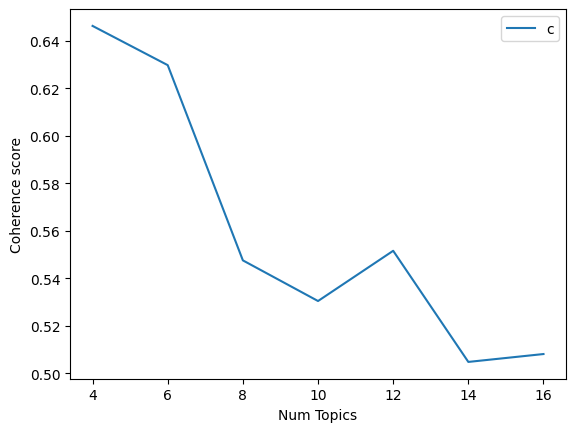

<Figure size 640x480 with 0 Axes>

In [ ]:
# @title Coherence exploration with different topic number
import matplotlib.pyplot as plt

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, passes=10, alpha='auto', num_topics=num_topics)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

my_start=4
my_limit=18
my_step=2

model_list, coherence_values = compute_coherence_values(dictionary=dict_temp,
                                                        corpus=corpus_temp,
                                                        texts=documents_temp,
                                                        start=my_start, limit=my_limit, step=my_step)
# Show graph
x = range(my_start, my_limit, my_step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig(path + '/images/SCORE1.png')
plt.show()

In [ ]:
#Save Model list
directory = path + '/preprocModels'
# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
with open('/' + 'lda_model_list.pickle', 'wb') as f:
    pickle.dump(model_list, f)

Let's see how the topic distribution looks like! We use pyLDAvis charts

###PyLDAvis charts

Topic modeling is useful, but it’s difficult to understand it just by looking at a combination of words and numbers. One of the most effective ways to understand data is through visualization, and PyLDAvis is all about it.

In the PyLDAvis chart:
* **Each bubble represents a topic**. The larger the bubble, the higher percentage of the number of documents in the corpus is about that topic.
* Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.
* Red bars give the estimated number of times a given term was generated by a given topic.

>**A good topic model will have big and non-overlapping bubbles scattered throughout the chart.**

The `prepare` method of pyLDAvis build the chart with the following input:
* The LDA gensim model.
* The corpus bag of word.
* The dictionary.
* A dimensionality reduction function: we use `mmds`, which stands for **metric multidimensional scaling**. Given a distance matrix with the distances between each pair of objects (topics, in our case) in a set, and a chosen number of dimensions $N$, an MDS algorithm places each object into N-dimensional space (a lower-dimensional representation) such that the between-object distances are preserved as well as possible.

Below we show the topic distribution output from the models trained with 4, 6, 8, 10 and 12 topics.

In these example we can see different levels of detail in the topics. Because the purposes of topic modeling are several, we can choose the desired **degree of detail**. If we want just a **general overview** of the main contents in the corpus, it's better to maintain low the topic number. On the other hand, if a more **specific vision** is required, it's better to increase the number in order to raise the details.

An interesting fact issues looking at the **coherence score: it's higher when the topic number is low**. This suggest that this metrics not always reflects
what we want.
> Particularly, **it could be dangerous to compare different models trained with different topic numbers only relying on coherence score. This could be totally misleading!<br>
That's another proof that human judgement always has final word in checking topic modeling quality.**

Perhaps the comparison with the coherence score of models different in preprocessing instead of topic number could be more accurate from a human point of view. We'll investigate that later.

---

Nevertheless, since the 12-topic model shows some incoherent topic, like the *number 6*:
> cowboy formation surfing feature mesa natural_landform alien believe structure region look image gain ride_wave natural_formation

We will use 10 topic, which are all pretty consistent, to explore different preprocessing combinations. Furthermore, **using a low topic number is advised to better focus on how the preprocessing affects the result.**


In [ ]:
vis = pyLDAvis.gensim.prepare(model_list[0], corpus_temp, dict_temp, mds='mmds')
vis

/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.277533 -0.178352       1        1  33.676288
3     -0.204984  0.272243       2        1  29.827881
0      0.196507 -0.299596       3        1  22.719357
1      0.286010  0.205706       4        1  13.776473, topic_info=                                Term          Freq         Total Category  \
1802                         student  87992.000000  87992.000000  Default   
99                             state  26555.000000  26555.000000  Default   
16                               car  43076.000000  43076.000000  Default   
199                           system  20641.000000  20641.000000  Default   
4838                         explore  16315.000000  16315.000000  Default   
...                              ...           ...           ...      ...   
84562  candidate_broad_transregional    873.086204    873.802662   Topic4   
966                          believe   2339.152263   3194.508499   Topic4   
25                           country   2802.714816   4173.030814   Topic4   
485                          citizen   1291.791667   2480.934965   Topic4   
628                          process   1101.227747   1425.013569   Topic4   

       logprob  loglift  
1802   30.0000  30.0000  
99     29.0000  29.0000  
16     28.0000  28.0000  
199    27.0000  27.0000  
4838   26.0000  26.0000  
...        ...      ...  
84562  -6.1830   1.9814  
966    -5.1975   1.6706  
25     -5.0167   1.5842  
485    -5.7913   1.3296  
628    -5.9509   1.7245  

[188 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
1941       2  0.999893   accident
359        1  0.999867   activity
13623      1  0.895005  adventure
13623      3  0.105042  adventure
11456      1  0.999411     advice
...      ...       ...        ...
646        4  0.999873      voter
8212       3  0.999834       wave
648        4  0.999672        win
110        1  0.999663       work
357        1  0.999899      world

[197 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

In [ ]:
vis = pyLDAvis.gensim.prepare(model_list[1], corpus_temp, dict_temp, mds='mmds')
vis

/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.107703 -0.144513       1        1  30.333929
4     -0.215203  0.344935       2        1  17.733961
3      0.162766 -0.406892       3        1  15.011157
5      0.190018  0.326050       4        1  14.274460
2      0.394395 -0.008656       5        1  12.943690
0     -0.424272 -0.110924       6        1   9.702804, topic_info=          Term          Freq         Total Category  logprob  loglift
1802   student  74943.000000  74943.000000  Default  30.0000  30.0000
99       state  26226.000000  26226.000000  Default  29.0000  29.0000
16         car  43872.000000  43872.000000  Default  28.0000  28.0000
199     system  20385.000000  20385.000000  Default  27.0000  27.0000
5518   emotion  21274.000000  21274.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
303        new   1993.821038   3786.843966   Topic6  -5.0067   1.6913
6463     sport   1015.117498   1302.662092   Topic6  -5.6817   2.0833
2898   involve    917.324175   1187.463316   Topic6  -5.7830   2.0746
762   decision   1104.965226   2123.695708   Topic6  -5.5969   1.6794
758   consider    928.538841   1235.708328   Topic6  -5.7709   2.0470

[273 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
3714       2  0.999433       ability
962        2  0.999792          able
1941       1  0.999885      accident
210        1  0.167609        action
210        6  0.831698        action
...      ...       ...           ...
648        5  0.999585           win
110        2  0.999625          work
357        6  0.999809         world
20995      6  0.999032     young_man
1615       1  0.999542  young_people

[314 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 6, 3, 1])

In [ ]:
vis = pyLDAvis.gensim.prepare(model_list[2], corpus_temp, dict_temp, mds='mmds')
vis

/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.458653  0.090781       1        1  24.524734
1      0.279098  0.348408       2        1  17.855110
0      0.443222 -0.116220       3        1  13.280618
7      0.174571  0.034651       4        1  11.609949
4     -0.248738 -0.364152       5        1  11.372983
2     -0.125301  0.406375       6        1   9.771607
3      0.124149 -0.424615       7        1   8.205240
5     -0.188349  0.024771       8        1   3.379759, topic_info=                       Term          Freq         Total Category  logprob  \
1802                student  54720.000000  54720.000000  Default  30.0000   
99                    state  32369.000000  32369.000000  Default  29.0000   
16                      car  46286.000000  46286.000000  Default  28.0000   
343              technology  23947.000000  23947.000000  Default  27.0000   
2007                   face  27094.000000  27094.000000  Default  26.0000   
...                     ...           ...           ...      ...      ...   
1465            small_state   1154.352722   3883.587743   Topic8  -4.4986   
25                  country   1079.255583   4392.518090   Topic8  -4.5659   
804                   avoid    457.052452    896.055935   Topic8  -5.4251   
2834         argument_favor    388.029816    498.517098   Topic8  -5.5888   
681   presidential_election    435.817495   1523.566048   Topic8  -5.4727   

      loglift  
1802  30.0000  
99    29.0000  
16    28.0000  
343   27.0000  
2007  26.0000  
...       ...  
1465   2.1741  
25     1.9837  
804    2.7142  
2834   3.1368  
681    2.1358  

[353 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
3714       3  0.881142       ability
3714       4  0.117962       ability
962        2  0.977051          able
962        3  0.022526          able
800        6  0.999434       abolish
...      ...       ...           ...
357        2  0.999920         world
20995      5  0.998681     young_man
1615       1  0.913085  young_people
1615       2  0.057693  young_people
1615       4  0.028846  young_people

[402 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 1, 8, 5, 3, 4, 6])

In [ ]:
vis = pyLDAvis.gensim.prepare(model_list[3], corpus_temp, dict_temp, mds='mmds')
vis

/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.376393 -0.233888       1        1  27.256377
4     -0.062774  0.431756       2        1  15.029346
0     -0.305436  0.297087       3        1  11.926623
5      0.378831 -0.257131       4        1  11.127373
1      0.090743  0.036557       5        1   8.558057
7      0.457370  0.083960       6        1   7.612948
8      0.241875  0.339757       7        1   6.729310
6      0.104181 -0.376849       8        1   4.791196
9     -0.401685  0.035923       9        1   4.319197
2     -0.126712 -0.357171      10        1   2.649573, topic_info=            Term          Freq         Total Category  logprob  loglift
1802     student  70205.000000  70205.000000  Default  30.0000  30.0000
16           car  58337.000000  58337.000000  Default  29.0000  29.0000
343   technology  30724.000000  30724.000000  Default  28.0000  28.0000
388   experience  23107.000000  23107.000000  Default  27.0000  27.0000
99         state  23426.000000  23426.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
317        point    914.952545   1079.140938  Topic10  -4.4876   3.4657
905         case    782.837405    913.515866  Topic10  -4.6436   3.4764
3530     subject    786.159461    926.019220  Topic10  -4.6393   3.4670
6        article   3294.307247   8919.456538  Topic10  -3.2065   2.6347
2982   practical    762.770293   1022.344765  Topic10  -4.6695   3.3379

[414 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
3714       9  0.999559         ability
962       10  0.999673            able
1941       1  0.999855        accident
210        8  0.999787          action
37661      9  0.998438     action_unit
...      ...       ...             ...
1159       5  0.997874    win_election
3601       5  0.999195  win_presidency
357        3  0.999891           world
206        8  0.999220            year
1615       1  0.999800    young_people

[463 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 6, 2, 8, 9, 7, 10, 3])

In [ ]:
vis = pyLDAvis.gensim.prepare(model_list[4], corpus_temp, dict_temp, mds='mmds')
vis

/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.063845 -0.090960       1        1  20.424327
11     0.005919 -0.433308       2        1  14.221337
6     -0.412012 -0.171453       3        1  13.072014
7     -0.250523  0.409017       4        1  12.491793
3      0.282554 -0.379856       5        1   9.527855
5      0.433565 -0.124630       6        1   7.339433
10     0.057833  0.430497       7        1   5.620717
1     -0.236036 -0.353204       8        1   4.849653
4     -0.437361  0.113791       9        1   3.973521
9      0.276920  0.349762      10        1   3.586463
8      0.387272  0.126593      11        1   2.668635
2     -0.171976  0.123753      12        1   2.224252, topic_info=                     Term          Freq         Total Category  logprob  \
1802              student  94587.000000  94587.000000  Default  30.0000   
16                    car  70634.000000  70634.000000  Default  29.0000   
388            experience  21205.000000  21205.000000  Default  28.0000   
99                  state  32224.000000  32224.000000  Default  27.0000   
2007                 face  29957.000000  29957.000000  Default  26.0000   
...                   ...           ...           ...      ...      ...   
55511  presidency_receive    355.300561    356.416496  Topic12  -5.2586   
1320              prevent    918.500029   1361.731364  Topic12  -4.3088   
874               outcome    733.498302   1009.632609  Topic12  -4.5337   
256                ensure   2292.218389   8435.586226  Topic12  -3.3942   
427               promote    568.842195   1868.065673  Topic12  -4.7879   

       loglift  
1802   30.0000  
16     29.0000  
388    28.0000  
99     27.0000  
2007   26.0000  
...        ...  
55511   3.8026  
1320    3.4120  
874     3.4862  
256     2.5028  
427     2.6167  

[474 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
3714       4  0.963626       ability
3714       5  0.035981       ability
962        2  0.878505          able
962        4  0.089638          able
962        5  0.031594          able
...      ...       ...           ...
648        3  0.999400           win
357        2  0.999942         world
20995      6  0.998499     young_man
1615      11  0.999518  young_people
47605      2  0.999517           zoo

[513 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 12, 7, 8, 4, 6, 11, 2, 5, 10, 9, 3])

## Lemmatization vs stemming

We already have model trained with a lemmatized corpus! Let's create a stemmed corpus maintaining fixed all the other parameters, and see what changes.

In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for lemmatized-BOW model
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/2/term_topic.pickle', 'rb') as f: # Lemmatized
    term_topic_lemm = pickle.load(f)
with open(path+'/Modelli/2/lda_model.pickle', 'rb') as f: # Lemmatized
    lda_model_lemm = pickle.load(f)
with open(path+'/Modelli/2/corpus_bow', 'rb') as f: # Lemmatized
    corpus_bow_lemm = pickle.load(f)
with open(path+'/Modelli/2/id2word_diction', 'rb') as f: # Lemmatized
    id2word_diction_lemm = pickle.load(f)
styled_data = display(term_topic_lemm.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

Here we have ten topic pretty well formed. If we had to name some of them, we could say:
* Topic 0 refers to election and maybe more in particular with Electoral College Reform. Looking at the pyLDAvis chart below we can see that words beyond the 10th are consistent with it too. (note that the chart doesn't follow the same numeration of the table).
* Topic 7 deals with the challenge a city must face to reduce the traffic impact, where a different paradigma in transportation could help this transition.
* Topic three recalls astronomic studies about space exploration by humans, both with geographical references and also with the *alien* sub-topic.
* On the other hand, topic 5 is similar to topic 0, but with a more propagandistic accent, like a different **sentiment**. The word *water* is a bit out of context, who knows if in some documents water is seen as a political medium...

This leads us believing that, when heightening the granularity of the topics (i.e. increasing topic number) some words could be a little mismatched. If this occurs rarely the topic modeling quality isn't harmed. Again, because we don't know all the 50000 documents the model is trained on, there may be correlation between seemingly unrelated words, hence topic classification by human judgment has to be flexible and not too biased from the personal (limited) experience (a bit of it is still necessary).

In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for stemmed-BOW model
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/3/term_topic.pickle', 'rb') as f: # stemmed
    term_topic_stem = pickle.load(f)
with open(path+'/Modelli/3/lda_model.pickle', 'rb') as f: # stemmed
    lda_model_stem = pickle.load(f)
with open(path+'/Modelli/3/corpus_bow', 'rb') as f: # stemmed
    corpus_bow_stem = pickle.load(f)
with open(path+'/Modelli/3/id2word_diction', 'rb') as f: # stemmed
    id2word_diction_stem = pickle.load(f)
styled_data = display(term_topic_stem.style.applymap(lambda x: gradient_color(x, mixedValue=True)))

First thing that catches the eye: some words are brutally cutted off. Sometimes this can lead to a lack of meaning in stemmed words, or to multiple meanings.

Some **examples**: *fac*, *emot*, *express* (it could be meaningful but we already know it comes from *expression*, *presid*, *reduc*, *citi*.

Looking at the table, **topic 0** is a little messy: some words deal with emotions and expression, while others are out of context, like *mesa*. Topic 1 is ok and it can be summarized as personal relationships, as well as topic 2 which has a political background. No problems in topic 3, while the dealings between topic 4 words may be grasped with a little more difficulty: it talks about driving safety. Topic 5 is similar but the focus is shifted in changing the mobility standard. Topic 6 discuss of planets and studies about different kind of surfaces, maybe with some examples of the character who ride them (surfer for water, cowboy for desert...). **Sometimes it requires imagination!** Topic 7 is really messy, mainly for all the truncated words. The same goes for topic 8 and 9. Even looking at the pyLDAvis charts below, which have more words associated with topics, it's hard to decipher a coherent meaning.

In [ ]:
pyLDAvis.gensim.prepare(lda_model_lemm, corpus_bow_lemm, id2word_diction_lemm, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.215072  0.408188       1        1  17.922270
6      0.144432 -0.428758       2        1  13.184064
8      0.296500  0.313897       3        1  12.144038
9     -0.121854 -0.346110       4        1  11.032795
0     -0.400292  0.112407       5        1   9.198161
2      0.038381  0.336863       6        1   8.981791
1      0.359778 -0.225121       7        1   8.921442
3     -0.409973 -0.222672       8        1   8.438433
4      0.410215  0.055375       9        1   5.751553
5     -0.102116 -0.004069      10        1   4.425453, topic_info=              Term          Freq         Total Category  logprob  loglift
1802       student  63871.000000  63871.000000  Default  30.0000  30.0000
16             car  53259.000000  53259.000000  Default  29.0000  29.0000
343     technology  24375.000000  24375.000000  Default  28.0000  28.0000
99           state  24387.000000  24387.000000  Default  27.0000  27.0000
644           vote  21362.000000  21362.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
585      candidate   1206.562112   5729.998146  Topic10  -4.7239   1.5599
646          voter   1034.414134   4552.116281  Topic10  -4.8779   1.6360
784   popular_vote    934.180247   6992.569264  Topic10  -4.9798   1.1049
360       actually    628.320484   1137.905319  Topic10  -5.3764   2.5239
671         method    638.896854   1346.330812  Topic10  -5.3597   2.3724

[476 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
3714       2  0.998606       ability
3714       3  0.000766       ability
20382      2  0.998178      academic
2027       4  0.999252        access
1941       1  0.233150      accident
...      ...       ...           ...
206        8  0.074039          year
206       10  0.109902          year
20995      9  0.998714     young_man
1615       4  0.999817  young_people
47605      1  0.998791           zoo

[625 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 9, 10, 1, 3, 2, 4, 5, 6])

In [ ]:
pyLDAvis.gensim.prepare(lda_model_stem, corpus_bow_stem, id2word_diction_stem, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.008242 -0.038816       1        1  14.694415
5      0.059317 -0.433466       2        1  12.894733
1     -0.376649 -0.119373       3        1  12.700671
2     -0.191747  0.378435       4        1  12.274153
3      0.320509 -0.289034       5        1  11.571665
0      0.462936  0.000052       6        1  10.671823
6      0.110573  0.450927       7        1   9.380654
9     -0.240669 -0.340363       8        1   6.478101
8     -0.418167  0.159085       9        1   4.725455
7      0.282139  0.232551      10        1   4.608330, topic_info=                       Term          Freq         Total Category  logprob  \
2083                student  65636.000000  65636.000000  Default  30.0000   
15904                 venus  37885.000000  37885.000000  Default  29.0000   
126                   state  32132.000000  32132.000000  Default  28.0000   
908                  author  23183.000000  23183.000000  Default  27.0000   
424               technolog  28986.000000  28986.000000  Default  26.0000   
...                     ...           ...           ...      ...      ...   
3370               knowledg    933.888697   1629.451435  Topic10  -5.1006   
1736               influenc    754.211548   1142.172540  Topic10  -5.3143   
1921                 cultur    841.153460   1939.965298  Topic10  -5.2052   
52080  seek_multipl_opinion    779.828323   1823.244297  Topic10  -5.2809   
362                    lead    832.471788   2908.547153  Topic10  -5.2156   

       loglift  
2083   30.0000  
15904  29.0000  
126    28.0000  
908    27.0000  
424    26.0000  
...        ...  
3370    2.5207  
1736    2.6623  
1921    2.2417  
52080   2.2280  
362     1.8263  

[478 rows x 6 columns], token_table=       Topic      Freq                    Term
term                                          
4160      10  0.999464                    abil
1332       4  0.998239  abolish_elector_colleg
20301      5  0.998816                  academ
2349       2  0.772831                  access
2349       5  0.227089                  access
...      ...       ...                     ...
14600      9  0.999428                  you_ll
1869       1  0.033158             young_peopl
1869       2  0.901659             young_peopl
1869       5  0.064808             young_peopl
46685      1  0.999453                     zoo

[632 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 2, 3, 4, 1, 7, 10, 9, 8])

So far we've had a global overview of the topics. And it was evident that lemmatization provides topics whose words are better related than those seen on a stemmed corpus.

---
Now it's possible to see how they classify the same documents. We introduce a function in the module below which helps us looking both at the document and at its main topic at the same time.

In [ ]:
doc_and_topic(document_number=0, model_directory=[2, 3]) # 2 and 3 are the directories of models trained on lemmatized and stemmed corpus

Modello 2, Topic 7 : 0.7390480637550354

Modello 3, Topic 4 : 0.8641649484634399



DOCUMENT:
 Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.

In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go.

In [ ]:
doc_and_topic(document_number=10000, model_directory=[2, 3]) # 2 and 3 are the directories of models trained on lemmatized and stemmed corpus

Modello 2, Topic 3 : 0.6935111284255981

Modello 3, Topic 0 : 0.7333369255065918



DOCUMENT:
 The Face that appeared on Mars was something that all of us would never forget. We didn't know how it appeared or why it appeared, but we were going to figure it out. Some scientist including me think it was just a natural landform. Other scientist think it was created by aliens,but I highly doubt it was.

I'm here working with one of the other scientist, and we're talking about the Face that appeared on Mars. The scientist thinks that the face was madeby aliens but I think it wasn't that it's just a natural landform.

It was a natural landform because the caption that we put for people to see was " huge rock formation..... which resembles a human head... formed by shadows giving the illusion of eyes, nose, and mouth." The face was just a rock formation that gave the illusion of the eyes, nose, and mouth becuse it was just a shadow that we were seeing.

However the scientist doesn't think that. He thinks that the face was made by aliens. He says that there is no way it was j

In the example above we can see how stemmed model **fails to correctly classify** a document.

---

In [ ]:
doc_and_topic(document_number=20000, model_directory=[2, 3]) # 2 and 3 are the directories of models trained on lemmatized and stemmed corpus

Modello 2, Topic 4 : 0.303874671459198

Modello 3, Topic 7 : 0.7160620093345642



DOCUMENT:
 
Verbs are an essential part of the English language and play a key role in our writing. Using the right verb can add clarity and accuracy to a sentence and help ensure that the intended meaning is accurately conveyed. However, using the wrong verb can cause confusion and misinterpretation, which can lead to miscommunication. 

For example, if a sentence states that someone "ran quickly" instead of "sprinted quickly," the reader may assume the subject was running at a leisurely pace. This example highlights why it is important to use the correct verb in writing, which can be done by being thoughtful with one's word choice and referencing a dictionary if a certain verb is not certain.

On the other hand, if the wrong verb is used on purpose or with the intention to deceive the reader, then the consequences of using the wrong verb can be much more serious. Additionally, if the wrong verb is used in a legal or professional document (such as in a contract or court filing) the co

Apparently none of the models correctly classify this document: this suggest us that we could try with **a higher topic number**. We'll do this when we'll deal about modification on model hyperparameters. Right now this document contains a topic (which may be *english grammar*) which is not enough widespread in the corpus; other topics are more popular across the documents.

---
Ih the following, we'll maintain fixed the hyperparameter `use_lemmatization` to `True` because this provide us with **more readable** (i.e. interpretable) topic words, and even better correlated.

---
>**A note on coherence score**: lemmatized model has 12 percentage point more than the stemmed one. Until now it seems that coherence score could actually reflect the readability of words in topic, instead of only the correlation. This could derive from the clever way lemmatization use to normalizes words: it doesn't just cut the word, instead it try to reduce the term to its actual lemma.

##Stopwords

Stopwords are commonly used words in natural language that are typically filtered out before or after processing of text. These words are generally considered to have little semantic value, as they appear frequently across different documents and don't carry significant meaning on their own. In text processing tasks such as natural language processing (NLP) and information retrieval, stopwords are often removed to reduce noise and focus on more meaningful terms.

In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for lemmatized-BOW model WITH STOPWORDS
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/4/term_topic.pickle', 'rb') as f: # Lemmatized with stopwords
    term_topic_stop = pickle.load(f)
with open(path+'/Modelli/4/lda_model.pickle', 'rb') as f: # Lemmatized with stopwords
    lda_model_stop = pickle.load(f)
with open(path+'/Modelli/4/corpus_bow', 'rb') as f: # Lemmatized with stopwords
    corpus_bow_stop = pickle.load(f)
with open(path+'/Modelli/4/id2word_diction', 'rb') as f: # Lemmatized with stopwords
    id2word_diction_stop = pickle.load(f)
styled_data = display(term_topic_stop.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

As we expected, some **uninformative words appear** in the topics. And still worse, they aren't clustered in one - single - topic; instead they **spread** across some of them.

**Some topic are still unharmed** by that, but others show words apparently unrelated to the remaining ones. This happens especially in topics 4, 5 and 8 where pronouns and possessive adjectives occupy the top positions in topic words sorting (*you, your, he, his…*). Interestingly the algorithm recognizes and distinguishes these part of speech **in accord to their subject person**: topic 4 has pronoun of the second person, while 8 of the the first person plural, and so on.
Additionally, topic 8 words seem totally uncorrelated, even looking at pyLDAvis: we see words like *if* and *own* which don't carry any information. Topic 5 could deal with *driving accidents* (looking at the diagram below with more words), but it's messy.

Even if in the first ten words of some topics everything seems fine, other pronouns appear in the top 30 topic words. This happens in a couple of topics, but fortunately doesn't affect their interpretability. An example is **venus topic**, which clearly talks about spatial exploration, but has the generic and uninformative adjective  **its**.

---

Looking at the pyLDAvis chart, we can see that adding **stopwords leverages topic to be more uniform**: while before the first topic contained almost 18% of the tokens and the last one about 4%, here the first has 15% and the last has 7% of all the tokens.

In [ ]:
pyLDAvis.gensim.prepare(lda_model_stop, corpus_bow_stop, id2word_diction_stop, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.407011  0.077359       1        1  15.022833
5      0.013648  0.121946       2        1  14.795111
2     -0.280691  0.373144       3        1  11.849922
1      0.324932 -0.301791       4        1  11.120106
8      0.382423 -0.024404       5        1   8.623349
9      0.356971  0.270300       6        1   8.583551
4      0.067443  0.437365       7        1   8.557213
7      0.055583 -0.464289       8        1   7.703467
3     -0.359025 -0.256171       9        1   6.883085
6     -0.154274 -0.233459      10        1   6.861362, topic_info=                 Term          Freq         Total Category  logprob  loglift
185               you  93861.000000  93861.000000  Default  30.0000  30.0000
2249          student  64721.000000  64721.000000  Default  29.0000  29.0000
178                we  41419.000000  41419.000000  Default  28.0000  28.0000
17717           venus  41701.000000  41701.000000  Default  27.0000  27.0000
31                car  44885.000000  44885.000000  Default  26.0000  26.0000
...               ...           ...           ...      ...      ...      ...
613            source   1000.685981   1878.400748  Topic10  -5.4856   2.0495
807    electoral_vote   1245.459017   4281.125447  Topic10  -5.2668   1.4446
1005             keep    919.380093   1924.610204  Topic10  -5.5704   1.9405
19            because   1099.048546   8622.766139  Topic10  -5.3919   0.6193
775              want    865.734538   5125.065775  Topic10  -5.6305   0.9009

[491 rows x 6 columns], token_table=       Topic      Freq              Term
term                                    
4474       7  0.999226           ability
23249      3  0.999332          academic
71548      6  0.997719  academic_subject
2539       3  0.195629            access
2539       6  0.803622            access
...      ...       ...               ...
2017       1  0.000312      young_people
2017       6  0.999295      young_people
309        2  0.999945              your
639        2  0.999173          yourself
53355      1  0.999265               zoo

[649 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 3, 2, 9, 10, 5, 8, 4, 7])

Here the document classification is relatively straightforward: we suppose that if a topic is well formed, then probably a document dealing with that topic will be correctly classified. The same couldn't be said if a document is matched with a messy topic.

We compare the lemmatized-stopword model (right table) with the only-lemmatized one (left table).

In [ ]:
doc_and_topic(document_number=0, model_directory=[2, 4]) # 2 and 4 are the directories of models trained on lemmatized and lemm. with stopwords corpus

Modello 2, Topic 7 : 0.7390480637550354

Modello 4, Topic 0 : 0.8266466856002808



DOCUMENT:
 Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.

In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go.

In the example below a simple example of how topic are messy but still interpretable (in the right table)

In [ ]:
doc_and_topic(document_number=10000, model_directory=[2, 4]) # 2 and 4 are the directories of models trained on lemmatized and lemm. with stopwords corpus

Modello 2, Topic 3 : 0.6935111284255981

Modello 4, Topic 7 : 0.5446975827217102



DOCUMENT:
 The Face that appeared on Mars was something that all of us would never forget. We didn't know how it appeared or why it appeared, but we were going to figure it out. Some scientist including me think it was just a natural landform. Other scientist think it was created by aliens,but I highly doubt it was.

I'm here working with one of the other scientist, and we're talking about the Face that appeared on Mars. The scientist thinks that the face was madeby aliens but I think it wasn't that it's just a natural landform.

It was a natural landform because the caption that we put for people to see was " huge rock formation..... which resembles a human head... formed by shadows giving the illusion of eyes, nose, and mouth." The face was just a rock formation that gave the illusion of the eyes, nose, and mouth becuse it was just a shadow that we were seeing.

However the scientist doesn't think that. He thinks that the face was made by aliens. He says that there is no way it was j

In the table below we can see how a lower TFIDF score affect the result when letting stopwords in the training. Indeed: in the former, although we let stopwords,the TFIDF process most likely removed lot of them. Here we try to lower the threshold to see if allowing more stopwords change the result.

>Apparently, the most common stopwords remain pronouns: probably the TFDIDF doesn't cut them off because the TF is very large with respect to IDF, hence these words can overcome the threshold.

In practice, some topics are still dirty (6, 8, 9). Topic 8 is anyway interpretable as **experience and adventures**, while the 6 and 9 don't have a clear meaning.

> A new topic dealing with **work and marketing** comes out, where none of the previous models ever found it. Globally, the readability of these topics is acceptable (despite some words…), and this is reflected in a slightly higher coherence score.

In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for lemmatized-BOW model with stopwords and LOWER TFIDF threshold
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/5/term_topic.pickle', 'rb') as f: # Lemmatized with stopwords
    term_topic_stop = pickle.load(f)
with open(path+'/Modelli/5/lda_model.pickle', 'rb') as f: # Lemmatized with stopwords
    lda_model_stop = pickle.load(f)
with open(path+'/Modelli/5/corpus_bow', 'rb') as f: # Lemmatized with stopwords
    corpus_bow_stop = pickle.load(f)
with open(path+'/Modelli/5/id2word_diction', 'rb') as f: # Lemmatized with stopwords
    id2word_diction_stop = pickle.load(f)
styled_data = display(term_topic_stop.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

Removing stopwords can help improve the efficiency and effectiveness of the task by emphasizing the importance of content-bearing words and reducing the computational overhead associated with processing common, uninformative terms.

In the following, we'll fix the hyperparameter `maintain_stopwords` to `False` in order to get topic with only meaningful words.

##N-grams or not N-grams?


Sometimes words don't exists on their own. Occasionally, they are a component of a larger entity: an entity called N-gram, according to how many ($N$) units it has. In order to find if the use of N-grams has practical benefits, we take the lemmatized-no-stopword model with N-grams and try to remove them.

>The initial assumption is: since some words make sense only if they are part of an expression, a N-gram model should perform better.

Let's see if this is correct.

---
In the following we show both the former model (from training number 2), which do use N-grams, and the new model trained without them.







In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for lemmatized-BOW model
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/2/term_topic.pickle', 'rb') as f: # Lemmatized
    term_topic_lemm = pickle.load(f)
with open(path+'/Modelli/2/lda_model.pickle', 'rb') as f: # Lemmatized
    lda_model_lemm = pickle.load(f)
with open(path+'/Modelli/2/corpus_bow', 'rb') as f: # Lemmatized
    corpus_bow_lemm = pickle.load(f)
with open(path+'/Modelli/2/id2word_diction', 'rb') as f: # Lemmatized
    id2word_diction_lemm = pickle.load(f)
styled_data = display(term_topic_lemm.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for lemmatized-BOW model WITHOUT N-GRAMS
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/6/term_topic.pickle', 'rb') as f: # Lemmatized
    term_topic_nongrams = pickle.load(f)
with open(path+'/Modelli/6/lda_model.pickle', 'rb') as f: # Lemmatized
    lda_model_nongrams = pickle.load(f)
with open(path+'/Modelli/6/corpus_bow', 'rb') as f: # Lemmatized
    corpus_bow_nongrams = pickle.load(f)
with open(path+'/Modelli/6/id2word_diction', 'rb') as f: # Lemmatized
    id2word_diction_nongrams = pickle.load(f)
styled_data = display(term_topic_nongrams.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

Both the models seem to behave fine. Main differences are:
* In the first one we have a little more of context, given that words usually next to each other are packed in a single term.
* topics apparently similar to each other (between the models) have a deeply different meaning:
>1. Look at topic 2 (first table) and 6 (second table). Both share the word *technology* in the first place, hence this is the most important word for this topics. However, the former deals with *safety* while the latter deals with *education and lifestyle*.
>2. Topic 4 in the first table has a major outliers: the first word! *car_free_city* should have been in topic 7, whit all the other terms related to cars and transportation. The remaining words of topic 4 deals with *nature and adventure*.

* At a first glance, the model without N-grams seems to have better correlated words in all the topics. This is reflected in a higher **coherence score**, but note that this metrics **could have been artificially boosted due to the smaller number of words** (no N-grams means a narrower vocabulary) the model is trained on.

Nevertheless, **using or not N-grams is up to the user**. N-grams could help allowing context to enter in the topics (while normally this isn't realized, due to the BOW representation of the documents), but sometimes pure words are preferred. In our case pure words worked better, but it could've just been a chance! In the following presentation we'll try again to compare model with or without N-grams, in order to see better their effect on the result.

In [ ]:
pyLDAvis.gensim.prepare(lda_model_nongrams, corpus_bow_nongrams, id2word_diction_nongrams, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.387805  0.229165       1        1  18.353967
3      0.131695  0.402076       2        1  13.519985
0     -0.335931 -0.325832       3        1  12.683141
5     -0.142199  0.404278       4        1   9.877045
6      0.192276 -0.412696       5        1   9.665138
8     -0.332539  0.212312       6        1   9.076097
9     -0.075754 -0.328460       7        1   7.355620
2     -0.445288 -0.018022       8        1   7.072061
4      0.173233 -0.048702       9        1   6.360178
7      0.446701 -0.114119      10        1   6.036768, topic_info=          Term           Freq          Total Category  logprob  loglift
16         car  123526.000000  123526.000000  Default  30.0000  30.0000
1502   student   64248.000000   64248.000000  Default  29.0000  29.0000
616       vote   56872.000000   56872.000000  Default  28.0000  28.0000
125      state   45533.000000   45533.000000  Default  27.0000  27.0000
2283     phone   31313.000000   31313.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
464        try    2414.852589    2854.004526  Topic10  -4.5296   2.6402
329   personal    1940.931947    2519.717169  Topic10  -4.7481   2.5463
86         new    2811.734721    5957.830549  Topic10  -4.3775   2.0564
122      sport    1858.985797    3869.852118  Topic10  -4.7912   2.0741
5807    foster    1604.971044    2476.217312  Topic10  -4.9381   2.3737

[442 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
748        2  0.999607        abolish
12640      3  0.999647       academic
3447       1  0.999554  accessibility
1607       1  0.171844       accident
1607       9  0.828070       accident
...      ...       ...            ...
1960       6  0.999718         worthy
1221       7  0.998852          write
712        4  0.008883          young
712       10  0.991024          young
34301      4  0.999488            zoo

[574 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 6, 7, 9, 10, 3, 5, 8])

##TFIDF

TF-IDF is a cornerstone of document classification tasks, where the objective is to categorize documents into different groups.

A **key advantage** of TF-IDF is that it **balances out the term frequency** (how often a word appears in a document) and its **inverse document frequency** (how rare or common a word is in the entire corpus). This can greatly improve the quality of information retrieval and the performance of machine learning models that use text data.

Hence, TF-IDF works on the principle that words that are common in a document but uncommon in other documents in the corpus are more informative. These words are often the ones that help us understand what’s unique about a document.

$\text{TF}=\dfrac{\text{number of times a word appear in a doc}}{\text{total number of term in the doc}}$

$\text{IDF}=\log_2\dfrac{\text{total number of docs}}{\text{number of docs containing the term}}$

where

$\text{TF-IDF}=\text{TF}⋅\text{IDF}$

Here we specified the logarithm base because our Gensim implementation uses this value, however it can change from library to library.

---
Until now we trained some models with a random value for the lower threshold. **The reader is reminded that this threshold exclude some words from a document whether its TF-IDF score is subthreshold.**

 To begin the analysis of how TF-IDF affect the corpus (and consequently the results) let's start setting this value to ZERO: `lower_threshold = 0` as if no TF-IDF preprocess was implemented at all.


In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for lemmatized corpus with NO TF-IDF
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/7/term_topic.pickle', 'rb') as f:  # Lemmatized with NO TFIDF
    term_topic_NOtfidf = pickle.load(f)
with open(path+'/Modelli/7/lda_model.pickle', 'rb') as f:   # Lemmatized with NO TFIDF
    lda_model_NOtfidf = pickle.load(f)
with open(path+'/Modelli/7/corpus_bow', 'rb') as f:         # Lemmatized with NO TFIDF
    corpus_bow_NOtfidf = pickle.load(f)
with open(path+'/Modelli/7/id2word_diction', 'rb') as f:    # Lemmatized with NO TFIDF
    id2word_diction_NOtfidf = pickle.load(f)
with open(path+'/Modelli/7/dropped_words', 'rb') as f:      # Lemmatized with NO TFIDF
    dropped_words_NOtfidf = pickle.load(f)
styled_data = display(term_topic_NOtfidf.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

Topic 0 is ok: it clearly talks about presidential elections. Topic 3 too, it deals with emotion lessons and how technology can help in it. Topic 5 is the already well known topic referring to spatial exploration studies. Topic 6 deals with job opportunities and activities for students. Topic 7 still talks about election with a lot of word shared with topic 0, this is not good since we cannot distinct two nuances of meaning, hence we have repeated topics. The same is true for topic 1, 2 and 4. In these three topic there are many repetitions, but in practice we could save two of them: indeed we should blend together 1 and 2 because both refers to 'reducing car in cities to reduce  air pollution', and keep topic 4 as it deal with car technology and safety.
Topic 8 and 9 have some outliers (*seagoe*, *know*, *phone*) but at high level they talks about lifestyle and 'riding experiences' like surfing and cowboy-ing.

Obviously, this doesn't look like a good topic modeling, indeed we tried this value (`lower_threshold = 0`) as it is an end for the score interval (tf-idf cannot be lower than zero).

A glance at the pyLDAvis chart shows how **words are more shared across topic** (red bars don't fill the blue one) with respect to the former configurations, where words was usually associated to just one topic.

In [ ]:
pyLDAvis.gensim.prepare(lda_model_NOtfidf, corpus_bow_NOtfidf, id2word_diction_NOtfidf, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.096386  0.305997       1        1  16.106563
6      0.071395 -0.109197       2        1  15.913264
5     -0.130965 -0.333061       3        1  14.209699
1     -0.120594  0.145490       4        1   8.738760
2     -0.207439 -0.054388       5        1   8.704569
4     -0.314830 -0.060594       6        1   8.262336
7      0.322544  0.004717       7        1   8.128557
9     -0.206875  0.306174       8        1   7.948617
3      0.190386 -0.366373       9        1   7.057989
0      0.299993  0.161236      10        1   4.929646, topic_info=         Term           Freq          Total Category  logprob  loglift
16        car  132439.000000  132439.000000  Default  30.0000  30.0000
616      vote   67041.000000   67041.000000  Default  29.0000  29.0000
1502  student   68719.000000   68719.000000  Default  28.0000  28.0000
125     state   55716.000000   55716.000000  Default  27.0000  27.0000
2283    phone   31001.000000   31001.000000  Default  26.0000  26.0000
...       ...            ...            ...      ...      ...      ...
524      know    2807.477073   28894.969170  Topic10  -5.0074   0.6785
135      time    2872.802013   48067.910427  Topic10  -4.9844   0.1926
221     think    2337.069327   29406.189760  Topic10  -5.1908   0.4776
604   process    2143.073240   17977.836170  Topic10  -5.2775   0.8830
55       good    2146.362005   30387.755630  Topic10  -5.2759   0.3596

[776 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
748        7  0.518966        abolish
748       10  0.480760        abolish
11551      7  0.992191      abolition
12640      2  0.999886       academic
3447       5  0.229328  accessibility
...      ...       ...            ...
143        9  0.000049           year
143       10  0.058759           year
9464       9  0.008686       yearbook
9464      10  0.981565       yearbook
34301      1  0.999549            zoo

[2093 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 7, 6, 2, 3, 5, 8, 10, 4, 1])

In [ ]:
doc_and_topic(document_number=0, model_directory=[6, 7]) # 6 and 6 are the directories of models trained on lemmatized corpus with tfidf threshold value respectively: 0.9 and 0

Modello 6, Topic 1 : 0.7238019108772278

Modello 7, Topic 1 : 0.8834564685821533



DOCUMENT:
 Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.

In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go.

Here we can see that, even if the relationship between topics are not satisfying (we had repeated topics), the second model (with zero threshold) explains better the document: in particular the words `air` and `ban`.

Let's investigate the other end of the value interval.

What is the max value the TF-IDF score can assume? Look at the two part of the calculation. When drawing a specific word, IDF can reach $log_2(50000) ≈ 15$ if only one document has a this word. TF could even be equal to $1$ if all the terms in a document coincide with this word. In a more realistic scenario (even considering the length of our documents), maybe this specific word constitute a tenth of a document; so we can assess the TF-IDF score cannot be larger than $1.5$.

Since the former model was trained with `lower_threshold = 0.09`, pretty close to $0.1$, now we try other orders of magnitude:
* $10$, which is a very high value for this metric, so it's interesting to see how the model behave;
* $1$, probably still a high value;
* $0.001$ should be low enough to let many words we didn't see before enter in the topics.

In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for lemmatized corpus with TF-IDF threshold = 10
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/8/term_topic.pickle', 'rb') as f:  # Lemmatized with TFIDF = 10
    term_topic_tfidf10 = pickle.load(f)
with open(path+'/Modelli/8/lda_model.pickle', 'rb') as f:   # Lemmatized with TFIDF = 10
    lda_model_tfidf10 = pickle.load(f)
with open(path+'/Modelli/8/corpus_bow', 'rb') as f:         # Lemmatized with TFIDF = 10
    corpus_bow_tfidf10 = pickle.load(f)
with open(path+'/Modelli/8/id2word_diction', 'rb') as f:    # Lemmatized with TFIDF = 10
    id2word_diction_tfidf10 = pickle.load(f)
with open(path+'/Modelli/8/dropped_words', 'rb') as f:      # Lemmatized with TFIDF = 10
    dropped_words_tfidf10 = pickle.load(f)
styled_data = display(term_topic_tfidf10.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

We can see how only **misspelled** word survive the TF-IDF selection with a too high value. These will go in a list in order to tell SpaCy to remove them, when lemmatization is performed.

In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for lemmatized corpus with TF-IDF threshold = 1
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/9/term_topic.pickle', 'rb') as f:  # Lemmatized with TFIDF = 1
    term_topic_tfidf1 = pickle.load(f)
with open(path+'/Modelli/9/lda_model.pickle', 'rb') as f:   # Lemmatized with TFIDF = 1
    lda_model_tfidf1 = pickle.load(f)
with open(path+'/Modelli/9/corpus_bow', 'rb') as f:         # Lemmatized with TFIDF = 1
    corpus_bow_tfidf1 = pickle.load(f)
with open(path+'/Modelli/9/id2word_diction', 'rb') as f:    # Lemmatized with TFIDF = 1
    id2word_diction_tfidf1 = pickle.load(f)
with open(path+'/Modelli/9/dropped_words', 'rb') as f:      # Lemmatized with TFIDF = 1
    dropped_words_tfidf1 = pickle.load(f)
styled_data = display(term_topic_tfidf1.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

Here some correct words are present, like *service* and *email*, but the results are not useful at all.
Furthermore, there is a mismatch between the model term-topic map and the pyLDAvis chart, which means something is not correct. The `RuntimeWarning` in pyLDAvis may confirm this assumption. The output has been substituted by an image because the warning list is too long.

In [ ]:
pyLDAvis.gensim.prepare(lda_model_tfidf1, corpus_bow_tfidf1, id2word_diction_tfidf1, mds='mmds')

<img src="https://drive.google.com/uc?export=view&id=1me7e-TCwSciyW84H6-bIUkpW8X_wbpdD" width="800" height="600">

In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for lemmatized corpus with TF-IDF threshold = 0.001
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/10/term_topic.pickle', 'rb') as f:  # Lemmatized with TFIDF = 0.001
    term_topic_tfidf001 = pickle.load(f)
with open(path+'/Modelli/10/lda_model.pickle', 'rb') as f:   # Lemmatized with TFIDF = 0.001
    lda_model_tfidf001 = pickle.load(f)
with open(path+'/Modelli/10/corpus_bow', 'rb') as f:         # Lemmatized with TFIDF = 0.001
    corpus_bow_tfidf001 = pickle.load(f)
with open(path+'/Modelli/10/id2word_diction', 'rb') as f:    # Lemmatized with TFIDF = 0.001
    id2word_diction_tfidf001 = pickle.load(f)
with open(path+'/Modelli/10/dropped_words', 'rb') as f:      # Lemmatized with TFIDF = 0.001
    dropped_words_tfidf001 = pickle.load(f)
styled_data = display(term_topic_tfidf001.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

An interesting fact about the above model is that the topic are pretty well formed (except for topic 7…), but, **investigating deeper about the effect of the TF-IDF with $0.001$ threshold, we found that it differs from the NO-TFIDF model by just a word!** The for-loop below shows that only a document has been affected by this preprocess, in particular removing the word *help*.

**Hence, a single word can influence the entire model quality!**

In [ ]:
show_dropped_words(word_list = dropped_words_tfidf001)

Document: 821, Removed words: ['help']


In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for lemmatized corpus with TF-IDF threshold = 0.01
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/11/term_topic.pickle', 'rb') as f:  # Lemmatized with TFIDF = 0.01
    term_topic_tfidf01 = pickle.load(f)
with open(path+'/Modelli/11/lda_model.pickle', 'rb') as f:   # Lemmatized with TFIDF = 0.01
    lda_model_tfidf01 = pickle.load(f)
with open(path+'/Modelli/11/corpus_bow', 'rb') as f:         # Lemmatized with TFIDF = 0.01
    corpus_bow_tfidf01 = pickle.load(f)
with open(path+'/Modelli/11/id2word_diction', 'rb') as f:    # Lemmatized with TFIDF = 0.01
    id2word_diction_tfidf01 = pickle.load(f)
with open(path+'/Modelli/11/dropped_words', 'rb') as f:      # Lemmatized with TFIDF = 0.01
    dropped_words_tfidf01 = pickle.load(f)
styled_data = display(term_topic_tfidf01.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

In [ ]:
show_dropped_words(word_list = dropped_words_tfidf01, limit = 30)

Document: 4	 Removed words: ['conclusion', 'good', 'need', 'people', 'work', 'know']
Document: 5	 Removed words: ['conclusion']
Document: 9	 Removed words: ['time']
Document: 11	 Removed words: ['lead', 'way']
Document: 14	 Removed words: ['time', 'help']
Document: 21	 Removed words: ['get', 'need', 'use', 'year', 'easy', 'large', 'number', 'system', 'likely', 'second', 'come', 'person', 'right', 'want', 'process', 'happen', 'issue', 'different', 'able']
Document: 25	 Removed words: ['people']
Document: 27	 Removed words: ['time']
Document: 28	 Removed words: ['time']
Document: 29	 Removed words: ['life']


What a good-looking topics! All of them are adequately coherent and make sense. In addition, the coherence score of this model is the highest recorder yet, with a value of $0.70388$. We can see how TF-IDF doesn't modify every document: in the sample only a third of them were altered, and 80% only saw up to two different words removed.

Below, an overview of how the five tested tf-idf (0, 10, 1, 0.001, 0.01) values affect document classification.

In the following, we can keep this `lower_threshold` equal to $0.01$. Probably, the optimal value could change when the topic number will be adjusted, but this is up to the user preferences.

In [ ]:
doc_and_topic(document_number=0, model_directory=[7, 8, 9, 10, 11])

Modello 7, Topic 1 : 0.8834564685821533

Modello 8, Topic 0 : 0.10000000149011612

Modello 9, Topic 0 : 0.09999999403953552

Modello 10, Topic 7 : 0.5863458514213562

Modello 11, Topic 7 : 0.6958489418029785



DOCUMENT:
 Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.

In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go.

##Model analysis

###TOPIC NUMBER

**Let's try to increase the granularity of the topics. With a higher number of them, we should collect more detailed information.**  

What happens in practice is instead a strange phenomenon. Looking at the table, some topics seems really messy, with very uncorrelated words. But, is this the truth? This feeling could derive from:
* a poor knowledge of the dataset;
* a really large dataset with topics spanning across many fields, even very specific ones, with **jargon or idiomatic sentences which words are not really meaningful if taken on their own**.

**Note**: We also try to increase the TFIDF threshold (to $0.1$) to avoid the appearing of useless words, and then we'll compare this model with a copy of it that use a value ($0.02$) closer to the "optimal" one ($0.01$) found before.

For instance:
* topic zero is pretty odd, but could deal with *Communication and Persuasion*
* topic one is more straightforward in talking about *Community Development*
* topic 17 is odd as well, but with a bit of imagination it could refer to *change in society*.

Probably the best thing to do in this scenario is to evaluate the model directly on the documents.


In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for a model with 20 topics and TFIDF = 0.1
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/12/term_topic.pickle', 'rb') as f:  # Lemmatized with 20 topics and TFIDF = 0.1
    term_topic_20tpc = pickle.load(f)
with open(path+'/Modelli/12/lda_model.pickle', 'rb') as f:   # Lemmatized with 20 topics and TFIDF = 0.1
    lda_model_20tpc = pickle.load(f)
with open(path+'/Modelli/12/corpus_bow', 'rb') as f:         # Lemmatized with 20 topics and TFIDF = 0.1
    corpus_bow_20tpc = pickle.load(f)
with open(path+'/Modelli/12/id2word_diction', 'rb') as f:    # Lemmatized with 20 topics and TFIDF = 0.1
    id2word_diction_20tpc = pickle.load(f)
with open(path+'/Modelli/12/dropped_words', 'rb') as f:      # Lemmatized with 20 topics and TFIDF = 0.1
    dropped_words_20tpc = pickle.load(f)
styled_data = display(term_topic_20tpc.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

In [ ]:
pyLDAvis.gensim.prepare(lda_model_20tpc, corpus_bow_20tpc, id2word_diction_20tpc, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.120617  0.111858       1        1  17.874088
4      0.208672 -0.406393       2        1   9.731890
7     -0.160232 -0.096473       3        1   8.580928
10    -0.078950  0.493695       4        1   6.774306
3      0.319551 -0.360277       5        1   5.477884
18     0.443857 -0.173607       6        1   5.226742
9      0.144104  0.446612       7        1   4.995323
8     -0.278404 -0.411433       8        1   4.583451
19    -0.465232  0.162958       9        1   4.504646
15     0.300075  0.344129      10        1   3.857941
12     0.445132  0.203116      11        1   3.742584
14    -0.053465  0.276861      12        1   3.317136
1     -0.360090 -0.138503      13        1   3.260854
13    -0.288284  0.381299      14        1   3.132400
5     -0.007073 -0.489994      15        1   3.079576
2     -0.294787  0.171337      16        1   2.967906
11    -0.113193 -0.321456      17        1   2.784479
16    -0.489113 -0.128051      18        1   2.498435
0      0.173379 -0.087784      19        1   2.078152
17     0.433436  0.022105      20        1   1.531281, topic_info=            Term           Freq          Total Category  logprob  loglift
16           car  150168.000000  150168.000000  Default  30.0000  30.0000
616         vote   65954.000000   65954.000000  Default  29.0000  29.0000
2283       phone   41618.000000   41618.000000  Default  28.0000  28.0000
1135      planet   50113.000000   50113.000000  Default  27.0000  27.0000
1675      author   41000.000000   41000.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
2413       boost     236.605886     301.029880  Topic20  -5.3703   3.9383
690   generation     583.288541     994.239421  Topic20  -4.4680   3.6458
844      economy     413.731247    1095.137877  Topic20  -4.8115   3.2056
5324     outlook     179.458057     391.512849  Topic20  -5.6467   3.3990
1091       truck     100.828664     173.165298  Topic20  -6.2232   3.6382

[808 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
882      12  0.999586     able
748       2  0.999537  abolish
1047     19  0.994215    abuse
2177     13  0.996709   accept
1665      6  0.999506   access
...     ...       ...      ...
558      10  0.081772    wrong
558      12  0.535804    wrong
558      19  0.235193    wrong
143      18  0.999523     year
712       4  0.999781    young

[969 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 8, 11, 4, 19, 10, 9, 20, 16, 13, 15, 2, 14, 6, 3, 12, 17, 1, 18])

In [ ]:
show_dropped_words(word_list = dropped_words_20tpc, limit = 30) # Too many dropped words, lot of them has true impact in the meaning of the document

Document: 0	 Removed words: ['air', 'allow', 'apply', 'area', 'automobile', 'bad', 'big', 'bike', 'broad', 'build', 'bus', 'bustle', 'carintensive', 'cause', 'center', 'class', 'clear', 'conclusion', 'country', 'create', 'crop', 'current', 'devoid', 'dramatically', 'drive', 'driving', 'eerily', 'effort', 'emission', 'enforce', 'entire', 'environment', 'evennumbered', 'exhaust', 'expert', 'fact', 'family', 'famous', 'far', 'fine', 'following', 'gas', 'get', 'global', 'go', 'good', 'greenhouse', 'have', 'hike', 'hit', 'home', 'huge', 'idea', 'impact', 'impediment', 'leave', 'lesson', 'license', 'likewise', 'linchpin', 'live', 'long', 'lot', 'main', 'major', 'majorly', 'matter', 'maybe', 'middle', 'million', 'motorist', 'nearrecord', 'need', 'new', 'oddnumbered', 'order', 'park', 'partial', 'passenger', 'people', 'percent', 'permit', 'pit', 'play', 'pop', 'program', 'question', 'reason', 'reduce', 'replace', 'responsible', 'restriction', 'ride', 'role', 'rushhour', 'say', 'set', 'show', '

In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for a model with 20 topics and "optimal" TFIDF
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/13/term_topic.pickle', 'rb') as f:  # Lemmatized with 20 topics and "optimal" TFIDF
    term_topic_20tpc_OPT = pickle.load(f)
with open(path+'/Modelli/13/lda_model.pickle', 'rb') as f:   # Lemmatized with 20 topics and "optimal" TFIDF
    lda_model_20tpc_OPT = pickle.load(f)
with open(path+'/Modelli/13/corpus_bow', 'rb') as f:         # Lemmatized with 20 topics and "optimal" TFIDF
    corpus_bow_20tpc_OPT = pickle.load(f)
with open(path+'/Modelli/13/id2word_diction', 'rb') as f:    # Lemmatized with 20 topics and "optimal" TFIDF
    id2word_diction_20tpc_OPT = pickle.load(f)
with open(path+'/Modelli/13/dropped_words', 'rb') as f:      # Lemmatized with 20 topics and "optimal" TFIDF
    dropped_words_20tpc_OPT = pickle.load(f)
styled_data = display(term_topic_20tpc_OPT.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

In [ ]:
pyLDAvis.gensim.prepare(lda_model_20tpc_OPT, corpus_bow_20tpc_OPT, id2word_diction_20tpc_OPT, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.230412 -0.195825       1        1  9.668800
5     -0.378933 -0.161638       2        1  9.101573
11    -0.086245 -0.070707       3        1  8.208096
4     -0.077914 -0.248788       4        1  7.749640
9      0.274569  0.079561       5        1  7.250446
18    -0.268143  0.104244       6        1  6.193618
12    -0.250967  0.323560       7        1  6.165577
14    -0.269276 -0.329621       8        1  5.682227
6     -0.000836 -0.403988       9        1  5.290276
1      0.276907 -0.245865      10        1  4.813880
16     0.148691 -0.374623      11        1  4.348510
15     0.031314  0.413628      12        1  4.253795
13    -0.433895  0.149946      13        1  3.943989
0      0.096774  0.223203      14        1  3.339515
17    -0.111382  0.405878      15        1  3.207978
3     -0.065791  0.087847      16        1  3.192393
8      0.147067 -0.069605      17        1  3.178237
10     0.310665 -0.039436      18        1  3.049242
7      0.530073 -0.012854      19        1  0.807190
19     0.357733  0.365080      20        1  0.555019, topic_info=         Term           Freq          Total Category  logprob  loglift
16        car  152538.000000  152538.000000  Default  30.0000  30.0000
1502  student   78607.000000   78607.000000  Default  29.0000  29.0000
616      vote   67413.000000   67413.000000  Default  28.0000  28.0000
92     people   98032.000000   98032.000000  Default  27.0000  27.0000
2283    phone   33695.000000   33695.000000  Default  26.0000  26.0000
...       ...            ...            ...      ...      ...      ...
2383    water     390.156927    5908.790642  Topic20  -4.7634   2.4763
311     lower     310.108106    1552.560451  Topic20  -4.9930   3.5832
1961    adopt     333.625076    2636.737279  Topic20  -4.9199   3.1266
247    change     420.352273   23348.927301  Topic20  -4.6888   1.1767
407      high     371.112241   13167.042080  Topic20  -4.8134   1.6250

[1446 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
882       1  0.419077   able
882       2  0.020850   able
882       3  0.044975   able
882       4  0.003150   able
882       6  0.029165   able
...     ...       ...    ...
712       8  0.083374  young
712       9  0.190386  young
712      11  0.043944  young
712      15  0.002686  young
712      16  0.070804  young

[4834 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 12, 5, 10, 19, 13, 15, 7, 2, 17, 16, 14, 1, 18, 4, 9, 11, 8, 20])

In [ ]:
show_dropped_words(word_list = dropped_words_20tpc_OPT, limit = 30)

Document: 0	 Removed words: ['allow', 'conclusion', 'create', 'new', 'state', 'take', 'work', 'year']
Document: 1	 Removed words: ['create', 'use', 'benefit', 'life', 'system', 'think']
Document: 2	 Removed words: ['create', 'go', 'new', 'reason', 'take', 'thing', 'work', 'life', 'think', 'additionally', 'example', 'future', 'include', 'lead', 'look', 'technology', 'understand', 'well']
Document: 3	 Removed words: ['conclusion', 'good', 'need', 'new', 'time', 'life', 'world', 'help']
Document: 4	 Removed words: ['conclusion', 'good', 'home', 'leave', 'lot', 'major', 'matter', 'need', 'people', 'take', 'work', 'call', 'health', 'small', 'effective', 'especially', 'form', 'healthy', 'personal', 'technology', 'high', 'promote', 'alternative', 'citizen', 'decide', 'goal', 'know', 'right', 'safety', 'space', 'true']
Document: 5	 Removed words: ['conclusion', 'new', 'reason', 'year', 'mean', 'place', 'come', 'know', 'popular', 'process', 'support']
Document: 6	 Removed words: ['allow', 'crea

In the following we investigate how three different model classify five documents: the former one with just 10 topics, and both the models with 20 topics and tfidf threshold respectively equal to 0.1 and 0.02

####Some document classification



Here all the three models seems to perform very well. The third one may be the better, given the high score the right topic has.

In [ ]:
doc_and_topic(10, model_directory= [11, 12, 13])

Modello 11, Topic 6 : 0.7358249425888062

Modello 12, Topic 4 : 0.8458854556083679

Modello 13, Topic 1 : 0.9428207278251648



DOCUMENT:
 Dear senator, Retain the Electoral College. The Electoral College consists of 538 electors and a majority of 270 electors is is required to elect the President. Each state has hisher own electors which are chosen by the candidate political party. You should keep the Electoral College because you have certainty of outcome, and the President is everyones not just yours.

The first reason why you should stay with the Electoral College is because you are certain that the outcome will be in favor of one of the candidates. A tie in the nationwide electoral vote may happen but it is very unlikely that it will even though that 538number of electors in the Electoral College is a even numberS.3.For example in 2012's election, Obama received 61.7 percent of the electoral votes compared to 51.3 percent of the popular cast for him and rodney because all states award electoral votes on a winnertakeall basis even a slight plurality in a state creates a landslide electoralvote victory in th

Here, the model with `lower_threshold=0.1` totally misclassifies the document. This is a signal that the threshold should be maintained lower than 0.1. Model 11 and 13 have a similar belief about the topic, also in term of the relevance. We'd like to see a higher relevance for this topic, though.

In [ ]:
doc_and_topic(1000, model_directory= [11, 12, 13])

Modello 11, Topic 7 : 0.5745245814323425

Modello 12, Topic 19 : 0.43035849928855896

Modello 13, Topic 5 : 0.5583404302597046



DOCUMENT:
 Men are like ants. We are always in a rush and always desperate to arrive on time. The easiest way to arrive on time in any place, is by car. Cars, however, tend to do a lot more bad then they do good. Cars release large amounts of pollution and can raise smog and noise levels in areas where there is a lot of driving. Smog and pollution isn't very good for anybody, so some areas have taken preventative steps to keep Earth healthy and to keep people healthy as well. The shocking part is, the cars get cut out.

In some areas, like the experimental Vauban in Germany, cars are not allowed at all. No honking is heard when the sun rises, and streets are oddly empty. Shops are lined up within walking distance, and few buses run to allow for people to travel a little bit quicker. In fact, 70% of vaughn's population do not own cars, and many sold their cars for a chance to live in Vauban. The streets are safer, and people seem to be a lot less tense about things, when I had a car I w

Here model 12 get closer to the right classification, but it lacks a fundamental word for this document: *pollution*, which other models have. Again, the topic relevance is a little unsatisfying.

In [ ]:
doc_and_topic(4000, model_directory= [11, 12, 13])

Modello 11, Topic 7 : 0.5818493962287903

Modello 12, Topic 6 : 0.4883306324481964

Modello 13, Topic 5 : 0.6778838038444519



DOCUMENT:
 Cars are believed to be mandatory in life today. They get use where we need to go quicker that it is to walk or ride a bike. Cars have many positive effects, but also many negatives. The gas emission percentage from cars in several countries have risen dramtically. Many people say, having a car stresses you out. By cuttin down on car usage, our world could be a cleaner and stress relieved place.

In many middle-class populated cities, the amount of pollution is sky rocketing. Because of this, some cities like Vauban, Germany are making their communties car free. Doing this can cut down on the amount of gas that comes from the tail pipes of cars, making the enviroment healthier and making it easier to breathe. Not as many cities are going as extreme as Vauban, but they taking the extra measures. In Paris, France the amount of pollution to due to car usage was getting higher by day. So they enforced a partial drivng ban, if they didnt follow this law they would have to pay the

Pretty tragic results here, given that the relevance printed is related to the dominant topic. This can suggest two things:
* the model struggled to classify the document;
* the document has actually a wide variety of topics.

Reading the document, it's straightforward that it talks about very specific stuffs not particularly common in the corpus. These makes hard for the model to correctly focus on the actual meaning, leading it to prefer using more widespread topics. And this is what happens. If we increased the number of topics perhaps this document would have been classified better.


In [ ]:
doc_and_topic(25000, model_directory= [11, 12, 13])

Modello 11, Topic 4 : 0.4116175174713135

Modello 12, Topic 7 : 0.2639549970626831

Modello 13, Topic 2 : 0.1884620636701584



DOCUMENT:
 The digital age has been a game changer for how we approach our hobbies. Crafting, in particular, has seen huge changes in the past decade due to advancements in technology. No longer do crafters need to spend hours searching stores and websites for just the right supplies – digital craft tools make all that much easier. Digital crafting is becoming increasingly popular as more people are drawn to its convenience and ease of use. Crafters can now access materials virtually with the help of computer programs such as Adobe Photoshop or Illustrator, allowing them to create original designs without having to buy physical items. Not only does this save money but it also opens up whole new possibilities for creativity as there is no limit on what one can design digitally compared to a physical item like paper or fabric. These computer-aided design (CAD) programs have revolutionized the way individuals approach crafting projects by offering powerful tools that allow users to precis

Here, model 11 misclassifies the document, and it also have the strongest belief in the classification.
The best-performing model is 12, since it incorporates all the words and the meaning of this document. Model 13 is ok too, but it has a flaw: the word *surfing*.

In [ ]:
doc_and_topic(49999, model_directory= [11, 12, 13])

Modello 11, Topic 1 : 0.6316323280334473

Modello 12, Topic 8 : 0.46730753779411316

Modello 13, Topic 14 : 0.5383697748184204



DOCUMENT:
 Yes, today most the people have cellphones anything technological. But should we be able to operate cellphones while driving is the question everyone is concerned about. Everyone has different set of ideas about if people should be allowed to use their phones while driving. There are lots of advertising about phones and the cool things that they can do. And that you can test without having to stop looking at the road but those are all false advertising because you do. You must unlock your phone for you to be able to say the text just because we don't have to type it doesn't mean that is don't take our sight off the road. Some say it's wrong for you to text and drive and they are right it's wrong to do it because something can happen to us or more likely to someone else. It's easy for us to think that nothing can never happen to use if we text and drive at the same time, because it may have never happened to you but it doesn't mean that it hasn't happened to anyone else. Driv

### TOPIC'S DIRICHLET PRIOR

Until now an automated choice of the prior for the topic distribution was performed. We still have three options:
* To try a symmetric distribution: it uses a fixed symmetric prior of $\frac{1}{\text{num_topics}}$
* To try an asymmetric distribution: it uses a fixed normalized asymmetric prior of $\frac{1}{\text{topic_index} + \sqrt{\text{num_topics}}}$
* Try to pass an array of length equal to `num_topic` to denote an asymmetric user defined prior for each topic.

We maintain fixed the `lower_threshold = 0.02` and `num_topic = 20`: an high topic number can help the differences between models to better emerge when dealing right with the topic distribution.

In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for a model with 20 topics and SYMMETRIC ALPHA
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/14/term_topic.pickle', 'rb') as f:  # Lemmatized with 20 topics and SYMMETRIC ALPHA
    term_topic_20tpc_SYMM = pickle.load(f)
with open(path+'/Modelli/14/lda_model.pickle', 'rb') as f:   # Lemmatized with 20 topics and SYMMETRIC ALPHA
    lda_model_20tpc_SYMM = pickle.load(f)
with open(path+'/Modelli/14/corpus_bow', 'rb') as f:         # Lemmatized with 20 topics and SYMMETRIC ALPHA
    corpus_bow_20tpc_SYMM = pickle.load(f)
with open(path+'/Modelli/14/id2word_diction', 'rb') as f:    # Lemmatized with 20 topics and SYMMETRIC ALPHA
    id2word_diction_20tpc_SYMM = pickle.load(f)
with open(path+'/Modelli/14/dropped_words', 'rb') as f:      # Lemmatized with 20 topics and SYMMETRIC ALPHA
    dropped_words_20tpc_SYMM = pickle.load(f)
styled_data = display(term_topic_20tpc_SYMM.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

After a fast dataset skimming, it's possible to assert that most of them are mono-topic. A uniform distribution could perform well, even if some topics are more widespread than others. In practice, a symmetric distribution works well until a point where topics begin to show misspelled words (immediately inserted in the stopwords list). This happens mainly in topic 20. And topic 19 is really messy.

It's interesting to see how **minor topics like 17 and 18 shows better correlation than bigger topics like 13.**

In [ ]:
pyLDAvis.gensim.prepare(lda_model_20tpc_SYMM, corpus_bow_20tpc_SYMM, id2word_diction_20tpc_SYMM, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.049595  0.321498       1        1  11.228241
15     0.244056  0.312172       2        1   9.803484
12     0.115041  0.172844       3        1   8.303787
8     -0.059638  0.083453       4        1   7.904319
1      0.297654 -0.072647       5        1   7.857674
10    -0.129332 -0.210368       6        1   7.430909
5      0.169075  0.368793       7        1   7.335158
9     -0.249547 -0.050985       8        1   7.229230
0     -0.303973  0.170953       9        1   6.004411
13     0.287357  0.174677      10        1   5.196899
14     0.148366 -0.046772      11        1   4.927991
4     -0.344974 -0.181739      12        1   4.310761
3     -0.418600 -0.003147      13        1   3.595527
7     -0.132999  0.411172      14        1   3.159229
16     0.070520 -0.302784      15        1   2.478451
19    -0.319951  0.324749      16        1   2.137456
17     0.058715 -0.521882      17        1   0.382665
11    -0.240622 -0.459555      18        1   0.381968
6      0.368878 -0.361822      19        1   0.291312
2      0.489569 -0.128610      20        1   0.040528, topic_info=           Term           Freq          Total Category  logprob  loglift
16          car  138082.000000  138082.000000  Default  30.0000  30.0000
1502    student   75401.000000   75401.000000  Default  29.0000  29.0000
616        vote   64307.000000   64307.000000  Default  28.0000  28.0000
92       people   99184.000000   99184.000000  Default  27.0000  27.0000
125       state   57768.000000   57768.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
24493   ethical       0.051278       1.088857  Topic20 -11.0834   4.7553
12996    cowboy       0.051280       1.089246  Topic20 -11.0834   4.7550
13843    facial       0.051279       1.089431  Topic20 -11.0834   4.7548
20984     alien       0.051278       1.089288  Topic20 -11.0834   4.7549
20914  landform       0.051278       1.089234  Topic20 -11.0834   4.7550

[1387 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2769      2  0.002810  ability
2769      3  0.170598  ability
2769      4  0.439273  ability
2769      5  0.002944  ability
2769      6  0.217027  ability
...     ...       ...      ...
712       3  0.016995    young
712       4  0.090889    young
712       7  0.089275    young
712       9  0.626971    young
712      10  0.001076    young

[4315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 16, 13, 9, 2, 11, 6, 10, 1, 14, 15, 5, 4, 8, 17, 20, 18, 12, 7, 3])

In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for a model with 20 topics and A-SYMMETRIC ALPHA
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/15/term_topic.pickle', 'rb') as f:  # Lemmatized with 20 topics and A-SYMMETRIC ALPHA
    term_topic_20tpc_ASYMM = pickle.load(f)
with open(path+'/Modelli/15/lda_model.pickle', 'rb') as f:   # Lemmatized with 20 topics and A-SYMMETRIC ALPHA
    lda_model_20tpc_ASYMM = pickle.load(f)
with open(path+'/Modelli/15/corpus_bow', 'rb') as f:         # Lemmatized with 20 topics and A-SYMMETRIC ALPHA
    corpus_bow_20tpc_ASYMM = pickle.load(f)
with open(path+'/Modelli/15/id2word_diction', 'rb') as f:    # Lemmatized with 20 topics and A-SYMMETRIC ALPHA
    id2word_diction_20tpc_ASYMM = pickle.load(f)
with open(path+'/Modelli/15/dropped_words', 'rb') as f:      # Lemmatized with 20 topics and A-SYMMETRIC ALPHA
    dropped_words_20tpc_ASYMM = pickle.load(f)
styled_data = display(term_topic_20tpc_ASYMM.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

Here all the topic are pretty well formed, except for model 20. An idea could be to reduce the topic number by just one unit to see whether this model could perform better, or whether the asymmetric distribution is always prone to isolate *outliers* in the less important (i.e. the last) topic.

In [ ]:
pyLDAvis.gensim.prepare(lda_model_20tpc_ASYMM, corpus_bow_20tpc_ASYMM, id2word_diction_20tpc_ASYMM, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2      0.106488  0.306927       1        1  9.576798
6     -0.023184 -0.056941       2        1  9.264528
7     -0.165678  0.289114       3        1  8.336515
14    -0.413666  0.080627       4        1  8.072251
3     -0.337320 -0.072386       5        1  6.801181
10    -0.079850  0.391139       6        1  6.446061
1      0.341337 -0.103349       7        1  5.944907
17     0.173150 -0.053285       8        1  5.734459
18     0.138405  0.206353       9        1  5.024302
11    -0.179394  0.124271      10        1  4.832515
12    -0.297342 -0.237701      11        1  4.684313
19     0.307361  0.098730      12        1  3.816078
13    -0.345339  0.237601      13        1  3.755168
8      0.131813 -0.360064      14        1  3.231569
0      0.321390 -0.329349      15        1  3.176926
9      0.406566  0.087088      16        1  3.123763
15     0.265635  0.390012      17        1  2.969842
4     -0.003410 -0.339551      18        1  2.784729
5     -0.148878 -0.143146      19        1  2.350558
16    -0.198084 -0.516089      20        1  0.073535, topic_info=         Term           Freq          Total Category  logprob  loglift
1502  student   73242.000000   73242.000000  Default  30.0000  30.0000
16        car  139328.000000  139328.000000  Default  29.0000  29.0000
616      vote   65758.000000   65758.000000  Default  28.0000  28.0000
92     people   94127.000000   94127.000000  Default  27.0000  27.0000
3906  emotion   40409.000000   40409.000000  Default  26.0000  26.0000
...       ...            ...            ...      ...      ...      ...
3829     aime       2.269323       3.311815  Topic20  -7.8892   6.8371
4346   lament       2.259186       3.301678  Topic20  -7.8937   6.8357
3822     ahen       1.951804       2.994296  Topic20  -8.0399   6.7872
2100    black      42.648435     222.995674  Topic20  -4.9557   5.5610
1275     hole      26.891076     190.473011  Topic20  -5.4169   5.2574

[1403 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
882       1  0.369739   able
882       2  0.107734   able
882       3  0.031485   able
882       4  0.005719   able
882       6  0.124430   able
...     ...       ...    ...
712       6  0.046189  young
712       7  0.217100  young
712       9  0.025773  young
712      13  0.001516  young
712      16  0.004649  young

[4568 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 8, 15, 4, 11, 2, 18, 19, 12, 13, 20, 14, 9, 1, 10, 16, 5, 6, 17])

In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for a model with 19 topics and A-SYMMETRIC ALPHA
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/17/term_topic.pickle', 'rb') as f:  # Lemmatized with 20 topics and A-SYMMETRIC ALPHA
    term_topic_19tpc_ASYMM = pickle.load(f)
with open(path+'/Modelli/17/lda_model.pickle', 'rb') as f:   # Lemmatized with 20 topics and A-SYMMETRIC ALPHA
    lda_model_19tpc_ASYMM = pickle.load(f)
with open(path+'/Modelli/17/corpus_bow', 'rb') as f:         # Lemmatized with 20 topics and A-SYMMETRIC ALPHA
    corpus_bow_19tpc_ASYMM = pickle.load(f)
with open(path+'/Modelli/17/id2word_diction', 'rb') as f:    # Lemmatized with 20 topics and A-SYMMETRIC ALPHA
    id2word_diction_19tpc_ASYMM = pickle.load(f)
with open(path+'/Modelli/17/dropped_words', 'rb') as f:      # Lemmatized with 20 topics and A-SYMMETRIC ALPHA
    dropped_words_19tpc_ASYMM = pickle.load(f)
#styled_data = display(term_topic_19tpc_ASYMM.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

In [ ]:
pyLDAvis.gensim.prepare(lda_model_19tpc_ASYMM, corpus_bow_19tpc_ASYMM, id2word_diction_19tpc_ASYMM, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.215845 -0.147525       1        1  14.683605
13     0.083392 -0.333621       2        1  11.946478
10    -0.296192 -0.000422       3        1   8.117571
0     -0.370132 -0.161443       4        1   7.851585
9     -0.092318 -0.027030       5        1   6.761740
16     0.070133 -0.091685       6        1   6.037485
1      0.083715  0.219788       7        1   5.755554
4     -0.023973  0.356007       8        1   5.403195
8     -0.212581  0.202369       9        1   5.092175
17    -0.209061 -0.372316      10        1   4.915474
2     -0.068232 -0.374399      11        1   4.486082
18     0.224301 -0.343229      12        1   4.281676
12     0.268978  0.031063      13        1   3.057104
5      0.294984  0.197362      14        1   2.981047
3     -0.387677  0.120451      15        1   2.878343
14     0.299266 -0.238430      16        1   2.639929
6     -0.250988  0.403103      17        1   2.453222
7      0.248389  0.482843      18        1   0.333930
15     0.553843  0.077115      19        1   0.323803, topic_info=             Term           Freq          Total Category  logprob  loglift
92         people   91617.000000   91617.000000  Default  30.0000  30.0000
1502      student   84653.000000   84653.000000  Default  29.0000  29.0000
16            car  128273.000000  128273.000000  Default  28.0000  28.0000
616          vote   67600.000000   67600.000000  Default  27.0000  27.0000
125         state   55864.000000   55864.000000  Default  26.0000  26.0000
...           ...            ...            ...      ...      ...      ...
7363   misleading     101.229579     214.457377  Topic19  -5.5737   4.9821
10230         hub      83.839483     212.126036  Topic19  -5.7622   4.8045
1308   prioritize     226.502007    3671.245806  Topic19  -4.7683   2.9473
7055        cycle      92.363758     929.740038  Topic19  -5.6653   3.4236
2036     schedule      91.738509    1229.802680  Topic19  -5.6721   3.1371

[1344 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2769      1  0.006965  ability
2769      3  0.146795  ability
2769      4  0.016165  ability
2769      5  0.052305  ability
2769      6  0.243388  ability
...     ...       ...      ...
712       2  0.039825    young
712       5  0.114207    young
712       6  0.000211    young
712      12  0.438287    young
712      16  0.407417    young

[4237 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 14, 11, 1, 10, 17, 2, 5, 9, 18, 3, 19, 13, 6, 4, 15, 7, 8, 16])

In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for a model with 20 topics and A CUSTOM ALPHA
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/18/term_topic.pickle', 'rb') as f:  # Lemmatized with 20 topics and A CUSTOM ALPHA
    term_topic_20tpc_CSTM = pickle.load(f)
with open(path+'/Modelli/18/lda_model.pickle', 'rb') as f:   # Lemmatized with 20 topics and A CUSTOM ALPHA
    lda_model_20tpc_CSTM = pickle.load(f)
with open(path+'/Modelli/18/corpus_bow', 'rb') as f:         # Lemmatized with 20 topics and A CUSTOM ALPHA
    corpus_bow_20tpc_CSTM = pickle.load(f)
with open(path+'/Modelli/18/id2word_diction', 'rb') as f:    # Lemmatized with 20 topics and A CUSTOM ALPHA
    id2word_diction_20tpc_CSTM = pickle.load(f)
with open(path+'/Modelli/18/dropped_words', 'rb') as f:      # Lemmatized with 20 topics and A CUSTOM ALPHA
    dropped_words_20tpc_CSTM = pickle.load(f)
styled_data = display(term_topic_20tpc_CSTM.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

Since we found out that some topics are more widespread than other, we try to transfer this knowledge to the model fixing an adequate Dirichlet prior for topic distribution.

 In the chart below we can see a simplified case of our problem with a three-vertexes simplex. Each vertex stands for a topic, and if we assign each alpha a value equal to $\frac{1}{3}$, we can see how the topic density is sparse, with peaks near each vertex (representing that each document will likely be mono-topic). This is the case of a `symmetric` alpha, which results in topic having a prior of $\frac{1}{\text{num_topics}}$.

 Since we have more topic, this behaviour will be accentuated: $\frac{1}{20}\lt \frac{1}{3}$ thus more sparsity in the distribution. We do know that our documents actually have no more than one or two topics, hence we intervene adjusting the symmetric distribution [.05, .05, .05, .05, .05, .05, .05, .05, .05, .05, .05, .05, .05, .05, .05, .05, .05, .05, .05, .05] with a slightly different one that consider how some topics (cars, election, lifestyle, adventure, planets) are **more frequent than others (we raise a little their prior**, but not enough to result in a uniform distribution: we don't want that) and how sometimes they appear together.

 The new hypotetical prior vector could be: [.2, .2, .2, .2, .2, .2, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .05, .05, .05, .05]

 Looking both at the table above and at the pyLDAvis chart below we can notice that topic are actually really consistent! Seems our guess for the prior worked well. **This suggest us that a good behaviour in LDA topic modeling is**:
 1. begin the study with an automatically chosen alpha, in order to focus on preprocessing hyperparameters
 2. during the study, become confident with part of the dataset: if some random samples do share similarities, most documents probably do.
 3. aid the training by transferring the knowledge we built on the dataset to the model.



In [ ]:
show_simplex()

In [ ]:
vis = pyLDAvis.gensim.prepare(lda_model_20tpc_CSTM, corpus_bow_20tpc_CSTM, id2word_diction_20tpc_CSTM, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17     0.222664  0.305000       1        1  9.472472
10     0.042343 -0.306722       2        1  8.312777
2     -0.390481 -0.115045       3        1  7.110107
7      0.028337  0.119175       4        1  6.949142
9      0.205173 -0.083990       5        1  6.522779
5     -0.211294  0.082446       6        1  6.272378
1      0.205204  0.149104       7        1  5.878123
11    -0.303671 -0.249095       8        1  5.261193
3     -0.187058  0.397199       9        1  5.242819
14    -0.029587 -0.230093      10        1  5.096992
0     -0.077185  0.359829      11        1  4.583241
19    -0.150785 -0.097876      12        1  4.516348
8      0.191300 -0.272604      13        1  4.387856
4      0.116457  0.409316      14        1  4.218836
12     0.359301  0.148521      15        1  4.025613
16    -0.292554  0.204315      16        1  3.785793
13    -0.172417 -0.436094      17        1  3.503428
6     -0.430673  0.051941      18        1  3.420180
15     0.361584 -0.370561      19        1  0.751964
18     0.513342 -0.064765      20        1  0.687961, topic_info=           Term           Freq          Total Category  logprob  loglift
16          car  139257.000000  139257.000000  Default  30.0000  30.0000
1502    student   78297.000000   78297.000000  Default  29.0000  29.0000
616        vote   66017.000000   66017.000000  Default  28.0000  28.0000
2283      phone   35153.000000   35153.000000  Default  27.0000  27.0000
3897    emotion   28531.000000   28531.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
949        save     823.532678    6855.629559  Topic20  -4.2310   2.8600
1067       harm     503.387058    2106.947978  Topic20  -4.7233   3.5476
1593       cost     727.722976    9475.079733  Topic20  -4.3547   2.4127
682   expensive     516.493871    3003.905673  Topic20  -4.6976   3.2186
320   necessary     528.224975    5362.783285  Topic20  -4.6751   2.6615

[1430 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2769      2  0.007009  ability
2769      3  0.003967  ability
2769      4  0.041393  ability
2769      6  0.322017  ability
2769      8  0.000132  ability
...     ...       ...      ...
712       4  0.803830    young
712       5  0.076323    young
712       7  0.099058    young
712       8  0.008336    young
712      14  0.001083    young

[4673 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 11, 3, 8, 10, 6, 2, 12, 4, 15, 1, 20, 9, 5, 13, 17, 14, 7, 16, 19])

####Some document classification



Model peculiarities in the order:
* Model 13 has `auto` alpha;
* Model 14 has `symmetric` alpha;
* Model 15 has `asymmetric` alpha;
* Model 18 has custom alpha;

In [ ]:
doc_and_topic(10, model_directory= [13, 14, 15, 18])

Modello 13, Topic 1 : 0.9428207278251648

Modello 14, Topic 1 : 0.9757830500602722

Modello 15, Topic 19 : 0.7604900598526001

Modello 18, Topic 0 : 0.9823521375656128



DOCUMENT:
 Dear senator, Retain the Electoral College. The Electoral College consists of 538 electors and a majority of 270 electors is is required to elect the President. Each state has hisher own electors which are chosen by the candidate political party. You should keep the Electoral College because you have certainty of outcome, and the President is everyones not just yours.

The first reason why you should stay with the Electoral College is because you are certain that the outcome will be in favor of one of the candidates. A tie in the nationwide electoral vote may happen but it is very unlikely that it will even though that 538number of electors in the Electoral College is a even numberS.3.For example in 2012's election, Obama received 61.7 percent of the electoral votes compared to 51.3 percent of the popular cast for him and rodney because all states award electoral votes on a winnertakeall basis even a slight plurality in a state creates a landslide electoralvote victory in th

In [ ]:
doc_and_topic(1000, model_directory=[13, 14, 15, 18])

Modello 13, Topic 5 : 0.5583404302597046

Modello 14, Topic 5 : 0.6205148100852966

Modello 15, Topic 7 : 0.6606372594833374

Modello 18, Topic 9 : 0.7263502478599548



DOCUMENT:
 Men are like ants. We are always in a rush and always desperate to arrive on time. The easiest way to arrive on time in any place, is by car. Cars, however, tend to do a lot more bad then they do good. Cars release large amounts of pollution and can raise smog and noise levels in areas where there is a lot of driving. Smog and pollution isn't very good for anybody, so some areas have taken preventative steps to keep Earth healthy and to keep people healthy as well. The shocking part is, the cars get cut out.

In some areas, like the experimental Vauban in Germany, cars are not allowed at all. No honking is heard when the sun rises, and streets are oddly empty. Shops are lined up within walking distance, and few buses run to allow for people to travel a little bit quicker. In fact, 70% of vaughn's population do not own cars, and many sold their cars for a chance to live in Vauban. The streets are safer, and people seem to be a lot less tense about things, when I had a car I w

In [ ]:
doc_and_topic(4000, model_directory= [13, 14, 15, 18])

Modello 13, Topic 5 : 0.6778838038444519

Modello 14, Topic 5 : 0.7660903334617615

Modello 15, Topic 7 : 0.8675171732902527

Modello 18, Topic 9 : 0.8208716511726379



DOCUMENT:
 Cars are believed to be mandatory in life today. They get use where we need to go quicker that it is to walk or ride a bike. Cars have many positive effects, but also many negatives. The gas emission percentage from cars in several countries have risen dramtically. Many people say, having a car stresses you out. By cuttin down on car usage, our world could be a cleaner and stress relieved place.

In many middle-class populated cities, the amount of pollution is sky rocketing. Because of this, some cities like Vauban, Germany are making their communties car free. Doing this can cut down on the amount of gas that comes from the tail pipes of cars, making the enviroment healthier and making it easier to breathe. Not as many cities are going as extreme as Vauban, but they taking the extra measures. In Paris, France the amount of pollution to due to car usage was getting higher by day. So they enforced a partial drivng ban, if they didnt follow this law they would have to pay the

In [ ]:
doc_and_topic(25000, model_directory= [13, 14, 15, 18])

Modello 13, Topic 2 : 0.1884620636701584

Modello 14, Topic 13 : 0.48114514350891113

Modello 15, Topic 6 : 0.2719935178756714

Modello 18, Topic 19 : 0.2768007814884186



DOCUMENT:
 The digital age has been a game changer for how we approach our hobbies. Crafting, in particular, has seen huge changes in the past decade due to advancements in technology. No longer do crafters need to spend hours searching stores and websites for just the right supplies – digital craft tools make all that much easier. Digital crafting is becoming increasingly popular as more people are drawn to its convenience and ease of use. Crafters can now access materials virtually with the help of computer programs such as Adobe Photoshop or Illustrator, allowing them to create original designs without having to buy physical items. Not only does this save money but it also opens up whole new possibilities for creativity as there is no limit on what one can design digitally compared to a physical item like paper or fabric. These computer-aided design (CAD) programs have revolutionized the way individuals approach crafting projects by offering powerful tools that allow users to precis

In [ ]:
doc_and_topic(49999, model_directory= [13, 14, 15, 18])

Modello 13, Topic 14 : 0.5383697748184204

Modello 14, Topic 18 : 0.5816840529441833

Modello 15, Topic 10 : 0.5087406635284424

Modello 18, Topic 1 : 0.6219473481178284



DOCUMENT:
 Yes, today most the people have cellphones anything technological. But should we be able to operate cellphones while driving is the question everyone is concerned about. Everyone has different set of ideas about if people should be allowed to use their phones while driving. There are lots of advertising about phones and the cool things that they can do. And that you can test without having to stop looking at the road but those are all false advertising because you do. You must unlock your phone for you to be able to say the text just because we don't have to type it doesn't mean that is don't take our sight off the road. Some say it's wrong for you to text and drive and they are right it's wrong to do it because something can happen to us or more likely to someone else. It's easy for us to think that nothing can never happen to use if we text and drive at the same time, because it may have never happened to you but it doesn't mean that it hasn't happened to anyone else. Driv

### MORE EPOCHS

Here model 13 (auto alpha and 15 epochs training) is compared with model 19, which has been trained on a higher number of epochs: 40.

More epochs should mean more overfitting on the dataset, thus more accuracy in the classification. Unfortunately this doesn't have a positive impact, since the last topics contain undesirable misspelled words.

A visible effect emerge in the pyLDAvis chart, where **similar topics are closer. In the former chart similar topics weren't so close.**

In [ ]:
# @title Importing dataframes for the model with 20 topics, auto alpha, 40 epochs
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/19/term_topic.pickle', 'rb') as f:  # Lemmatized with 20 topics, auto alpha, 40 epochs
    term_topic_20tpc_40epch = pickle.load(f)
with open(path+'/Modelli/19/lda_model.pickle', 'rb') as f:   # Lemmatized with 20 topics, auto alpha, 40 epochs
    lda_model_20tpc_40epch = pickle.load(f)
with open(path+'/Modelli/19/corpus_bow', 'rb') as f:         # Lemmatized with 20 topics, auto alpha, 40 epochs
    corpus_bow_20tpc_40epch = pickle.load(f)
with open(path+'/Modelli/19/id2word_diction', 'rb') as f:    # Lemmatized with 20 topics, auto alpha, 40 epochs
    id2word_diction_20tpc_40epch = pickle.load(f)
with open(path+'/Modelli/19/dropped_words', 'rb') as f:      # Lemmatized with 20 topics, auto alpha, 40 epochs
    dropped_words_20tpc_40epch = pickle.load(f)
#styled_data = display(term_topic_20tpc_40epch.style.applymap(lambda x: gradient_color(x,mixedValue=True)))
pyLDAvis.gensim.prepare(lda_model_20tpc_40epch, corpus_bow_20tpc_40epch, id2word_diction_20tpc_40epch, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.325251  0.013731       1        1  10.610937
1      0.341224  0.240370       2        1   7.202063
3     -0.194558  0.327377       3        1   6.578106
12    -0.242252 -0.234662       4        1   6.571949
17    -0.233222  0.220275       5        1   6.156660
4     -0.065774 -0.146701       6        1   6.005451
16    -0.156477 -0.372572       7        1   5.897553
7      0.111954 -0.274079       8        1   5.603789
11     0.124956  0.070829       9        1   5.492396
5     -0.116677  0.054216      10        1   5.488318
13     0.338844 -0.123369      11        1   5.415988
14     0.002161  0.339289      12        1   5.202624
8      0.156941  0.320753      13        1   5.035446
19     0.350033  0.161520      14        1   4.630313
10    -0.086509  0.390177      15        1   3.788800
0     -0.460174  0.094852      16        1   3.389042
9     -0.300666 -0.013635      17        1   3.301847
15    -0.410829 -0.199880      18        1   3.015789
18     0.396979 -0.347253      19        1   0.565563
6      0.118795 -0.521237      20        1   0.047364, topic_info=              Term           Freq          Total Category  logprob  loglift
1502       student   76944.000000   76944.000000  Default  30.0000  30.0000
16             car  136284.000000  136284.000000  Default  29.0000  29.0000
616           vote   66828.000000   66828.000000  Default  28.0000  28.0000
140            use   33687.000000   33687.000000  Default  27.0000  27.0000
2283         phone   31826.000000   31826.000000  Default  26.0000  26.0000
...            ...            ...            ...      ...      ...      ...
1276   irrefutable       2.700105       7.186642  Topic20  -7.2755   6.6761
8845    capitalize       1.911631      36.581119  Topic20  -7.6208   4.7035
3748         naive       0.950695      18.369894  Topic20  -8.3193   4.6938
20973        alien       0.034363       1.054032  Topic20 -11.6395   4.2317
13832       facial       0.034372       1.054826  Topic20 -11.6393   4.2312

[1382 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2769      5  0.132890  ability
2769      6  0.272561  ability
2769      8  0.202399  ability
2769      9  0.036776  ability
2769     10  0.129760  ability
...     ...       ...      ...
712       9  0.074284    young
712      10  0.061518    young
712      12  0.100696    young
712      13  0.058987    young
712      17  0.660299    young

[4008 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 13, 18, 5, 17, 8, 12, 6, 14, 15, 9, 20, 11, 1, 10, 16, 19, 7])

In [ ]:
# @title Importing dataframes for the model with 20 topics, auto alpha, 15 epochs
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/13/term_topic.pickle', 'rb') as f:  # Lemmatized with 20 topics, auto alpha, 15 epochs
    term_topic_20tpc_15epch = pickle.load(f)
with open(path+'/Modelli/13/lda_model.pickle', 'rb') as f:   # Lemmatized with 20 topics, auto alpha, 15 epochs
    lda_model_20tpc_15epch = pickle.load(f)
with open(path+'/Modelli/13/corpus_bow', 'rb') as f:         # Lemmatized with 20 topics, auto alpha, 15 epochs
    corpus_bow_20tpc_15epch = pickle.load(f)
with open(path+'/Modelli/13/id2word_diction', 'rb') as f:    # Lemmatized with 20 topics, auto alpha, 15 epochs
    id2word_diction_20tpc_15epch = pickle.load(f)
with open(path+'/Modelli/13/dropped_words', 'rb') as f:      # Lemmatized with 20 topics, auto alpha, 15 epochs
    dropped_words_20tpc_15epch = pickle.load(f)
#styled_data = display(term_topic_20tpc_15epch.style.applymap(lambda x: gradient_color(x,mixedValue=True)))
pyLDAvis.gensim.prepare(lda_model_20tpc_15epch, corpus_bow_20tpc_15epch, id2word_diction_20tpc_15epch, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.230412 -0.195825       1        1  9.668800
5     -0.378933 -0.161638       2        1  9.101573
11    -0.086245 -0.070707       3        1  8.208096
4     -0.077914 -0.248788       4        1  7.749640
9      0.274569  0.079561       5        1  7.250446
18    -0.268143  0.104244       6        1  6.193618
12    -0.250967  0.323560       7        1  6.165577
14    -0.269276 -0.329621       8        1  5.682227
6     -0.000836 -0.403988       9        1  5.290276
1      0.276907 -0.245865      10        1  4.813880
16     0.148691 -0.374623      11        1  4.348510
15     0.031314  0.413628      12        1  4.253795
13    -0.433895  0.149946      13        1  3.943989
0      0.096774  0.223203      14        1  3.339515
17    -0.111382  0.405878      15        1  3.207978
3     -0.065791  0.087847      16        1  3.192393
8      0.147067 -0.069605      17        1  3.178237
10     0.310665 -0.039436      18        1  3.049242
7      0.530073 -0.012854      19        1  0.807190
19     0.357733  0.365080      20        1  0.555019, topic_info=         Term           Freq          Total Category  logprob  loglift
16        car  152538.000000  152538.000000  Default  30.0000  30.0000
1502  student   78607.000000   78607.000000  Default  29.0000  29.0000
616      vote   67413.000000   67413.000000  Default  28.0000  28.0000
92     people   98032.000000   98032.000000  Default  27.0000  27.0000
2283    phone   33695.000000   33695.000000  Default  26.0000  26.0000
...       ...            ...            ...      ...      ...      ...
2383    water     390.156927    5908.790642  Topic20  -4.7634   2.4763
311     lower     310.108106    1552.560451  Topic20  -4.9930   3.5832
1961    adopt     333.625076    2636.737279  Topic20  -4.9199   3.1266
247    change     420.352273   23348.927301  Topic20  -4.6888   1.1767
407      high     371.112241   13167.042080  Topic20  -4.8134   1.6250

[1446 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
882       1  0.419077   able
882       2  0.020850   able
882       3  0.044975   able
882       4  0.003150   able
882       6  0.029165   able
...     ...       ...    ...
712       8  0.083374  young
712       9  0.190386  young
712      11  0.043944  young
712      15  0.002686  young
712      16  0.070804  young

[4834 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 12, 5, 10, 19, 13, 15, 7, 2, 17, 16, 14, 1, 18, 4, 9, 11, 8, 20])

###MORE TOPICS

In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for a model with 50 TOPICS
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/20/term_topic.pickle', 'rb') as f:  # Lemmatized with 50 TOPICS
    term_topic_50tpc = pickle.load(f)
with open(path+'/Modelli/20/lda_model.pickle', 'rb') as f:   # Lemmatized with 50 TOPICS
    lda_model_50tpc = pickle.load(f)
with open(path+'/Modelli/20/corpus_bow', 'rb') as f:         # Lemmatized with 50 TOPICS
    corpus_bow_50tpc = pickle.load(f)
with open(path+'/Modelli/20/id2word_diction', 'rb') as f:    # Lemmatized with 50 TOPICS
    id2word_diction_50tpc = pickle.load(f)
with open(path+'/Modelli/20/dropped_words', 'rb') as f:      # Lemmatized with 50 TOPICS
    dropped_words_50tpc = pickle.load(f)
styled_data = display(term_topic_50tpc.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

Until topic n°24 everything is ok, like the former models. After it we can see some topic aren't really consistent (see 28, 30, 35, 48), while others maintain their intrinsic meaning (39, 41, 42, etc.).
Last two topics still contain misspelled words (so we add them to the stopword list) and are not homogeneous.

In [ ]:
pyLDAvis.gensim.prepare(lda_model_50tpc, corpus_bow_50tpc, id2word_diction_50tpc, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
37    -0.181124  0.158447       1        1  6.854279
15     0.276738 -0.009802       2        1  5.821811
17     0.129850  0.396714       3        1  4.895370
18     0.063322  0.421863       4        1  4.585063
40    -0.068413  0.346394       5        1  4.144911
24     0.442925  0.055521       6        1  4.087731
49     0.028235  0.436161       7        1  4.035981
2     -0.162294  0.342370       8        1  4.020353
27    -0.051041  0.126796       9        1  3.729270
47     0.316785  0.330782      10        1  3.472328
34     0.048209  0.238641      11        1  3.361560
43     0.344416  0.156806      12        1  3.322306
19    -0.277332  0.294601      13        1  2.890022
42    -0.357488  0.252052      14        1  2.809234
25     0.257651  0.133345      15        1  2.804934
21    -0.250455  0.413497      16        1  2.592193
16    -0.103563  0.444424      17        1  2.504650
23    -0.240971  0.112657      18        1  2.363720
0      0.400835  0.283448      19        1  2.309817
14     0.172430  0.253805      20        1  2.075416
45     0.040791  0.001422      21        1  2.054621
5      0.167842 -0.217445      22        1  2.003365
48     0.243907  0.403638      23        1  1.963405
12     0.097860 -0.130809      24        1  1.900900
1      0.113593  0.159716      25        1  1.774382
28     0.387903 -0.008010      26        1  1.668226
9      0.475437 -0.121281      27        1  1.566182
36    -0.314527 -0.015721      28        1  1.496409
32     0.309188 -0.231545      29        1  1.325959
31    -0.191627 -0.139971      30        1  1.179383
26    -0.342991 -0.234704      31        1  1.157450
7      0.291952 -0.115077      32        1  1.097584
8     -0.103931 -0.029761      33        1  1.042627
46     0.186992 -0.372306      34        1  0.947474
10     0.305710 -0.395428      35        1  0.941007
11     0.429651 -0.286089      36        1  0.920477
22     0.448889  0.137013      37        1  0.893473
35    -0.053575 -0.212559      38        1  0.775576
4     -0.185195 -0.373261      39        1  0.535066
39    -0.000200 -0.395150      40        1  0.364725
30    -0.451076 -0.256499      41        1  0.292842
20    -0.461034  0.080922      42        1  0.288202
41    -0.120896 -0.515765      43        1  0.279928
3     -0.254921 -0.460646      44        1  0.226669
6     -0.524368  0.151045      45        1  0.150451
38    -0.525117 -0.050253      46        1  0.120111
33    -0.493667 -0.158760      47        1  0.115544
44    -0.353740 -0.377001      48        1  0.095556
13    -0.006660 -0.517524      49        1  0.087873
29     0.095091 -0.506711      50        1  0.053586, topic_info=         Term           Freq          Total Category  logprob  loglift
1502  student   74977.000000   74977.000000  Default  30.0000  30.0000
16        car  138472.000000  138472.000000  Default  29.0000  29.0000
616      vote   65224.000000   65224.000000  Default  28.0000  28.0000
1135   planet   34297.000000   34297.000000  Default  27.0000  27.0000
92     people  107418.000000  107418.000000  Default  26.0000  26.0000
...       ...            ...            ...      ...      ...      ...
0         air       0.020991   18187.037995  Topic50 -12.2862  -6.1405
1       allow       0.020991   21108.180653  Topic50 -12.2862  -6.2895
2       aloud       0.020991      64.804618  Topic50 -12.2862  -0.5034
3       apply       0.020991    2297.303331  Topic50 -12.2862  -4.0715
4        area       0.020991   13683.721745  Topic50 -12.2862  -5.8560

[3142 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
2769       3  0.071724  ability
2769       5  0.001779  ability
2769       8  0.043938  ability
2769       9  0.002738  ability
2769      10  0.050234  ability
...      ...       ...      ...
712        5  0.033707    young
712        8  0.044215 

In [ ]:
doc_and_topic(2880, model_directory= [20])

Modello 20, Topic 2 : 0.6742129325866699



DOCUMENT:
 Phones and driving aren't a good thing to do at the same time, in fact it's illegal and if the police find you they can fine you from $20-thousands of dollars, Suspension or revocation of driving privileges, Points on one's driving record, Mandatory road safety classes and Vehicle impoundment, especially if great bodily injury resulted from an accident. Every day in the United States around one out of ten people are killed by distracted drivers, and around 1500 are injured in some way in crashes by these irresponsible, distracted drivers. One of the most dangerous, distracting activities that many people do is texting while driving. It is extremely dangerous because people who do this are putting more attention in texting, and they take their eyes off the road while they are driving, which increases the chance that the driver can lose the control of the vehicle, and could cause a crash or even in a worst-case could kill other people. When a person is texting, she/he is think

In [ ]:
# @title Importing and displaying TERM-TOPIC dataframes for a model with 50 TOPICS and TRIGRAMS
path="/content/drive/MyDrive/NLP"
with open(path+'/Modelli/21/term_topic.pickle', 'rb') as f:  # Lemmatized with 50 TOPICS and TRIGRAMS
    term_topic_50tpc_trigr = pickle.load(f)
with open(path+'/Modelli/21/lda_model.pickle', 'rb') as f:   # Lemmatized with 50 TOPICS and TRIGRAMS
    lda_model_50tpc_trigr = pickle.load(f)
with open(path+'/Modelli/21/corpus_bow', 'rb') as f:         # Lemmatized with 50 TOPICS and TRIGRAMS
    corpus_bow_50tpc_trigr = pickle.load(f)
with open(path+'/Modelli/21/id2word_diction', 'rb') as f:    # Lemmatized with 50 TOPICS and TRIGRAMS
    id2word_diction_50tpc_trigr = pickle.load(f)
with open(path+'/Modelli/21/dropped_words', 'rb') as f:      # Lemmatized with 50 TOPICS and TRIGRAMS
    dropped_words_50tpc_trigr = pickle.load(f)
styled_data = display(term_topic_50tpc_trigr.style.applymap(lambda x: gradient_color(x,mixedValue=True)))

The issue here belongs in the last topics, where most of the N-grams accumulate. Thus these topic doesn't show a proper internal correlation.

In [ ]:
pyLDAvis.gensim.prepare(lda_model_50tpc_trigr, corpus_bow_50tpc_trigr, id2word_diction_50tpc_trigr, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
29     0.282237  0.367277       1        1  7.359521
23    -0.142300  0.307337       2        1  6.222156
24     0.215189  0.093054       3        1  5.431072
4      0.371769  0.294769       4        1  5.105864
32    -0.059719  0.401568       5        1  4.785694
8      0.001549  0.308257       6        1  4.616762
43     0.363237  0.101586       7        1  4.541038
26     0.294352  0.170546       8        1  4.390535
42     0.450056  0.100462       9        1  4.187014
27     0.207306  0.357661      10        1  4.070716
28     0.431730  0.223815      11        1  4.066049
31    -0.019101  0.156498      12        1  3.768895
41    -0.196948  0.419306      13        1  3.758272
12    -0.270715  0.360899      14        1  3.611836
20     0.218591  0.235929      15        1  3.412141
6      0.143077  0.094848      16        1  3.192475
25    -0.121379  0.162346      17        1  3.085346
1     -0.234342  0.172700      18        1  2.867188
45     0.158242  0.446952      19        1  2.700245
19    -0.298820  0.255694      20        1  2.461446
5      0.392558 -0.003490      21        1  2.046363
40     0.055124  0.450415      22        1  2.031925
15     0.115106  0.286917      23        1  1.576572
33    -0.383759  0.261125      24        1  1.563745
22    -0.098586  0.489981      25        1  1.454588
37    -0.432749  0.155948      26        1  1.196999
47    -0.418001  0.046542      27        1  1.143444
0     -0.504810  0.023853      28        1  1.008587
7      0.442201 -0.134284      29        1  0.666023
21    -0.391151 -0.338255      30        1  0.405233
49     0.289406 -0.187146      31        1  0.381033
3      0.389850 -0.280186      32        1  0.293056
2      0.330705 -0.355431      33        1  0.286356
46    -0.438080 -0.131981      34        1  0.277379
11     0.228866 -0.437490      35        1  0.272420
44    -0.011213 -0.505020      36        1  0.228567
14    -0.402317 -0.227716      37        1  0.211671
30     0.206396 -0.342946      38        1  0.175796
36    -0.292114 -0.176179      39        1  0.147322
13     0.091652 -0.443057      40        1  0.145308
9     -0.284110 -0.303174      41        1  0.142220
39    -0.125254 -0.446727      42        1  0.111010
16     0.105642 -0.304417      43        1  0.104936
38    -0.147322 -0.195410      44        1  0.098073
18     0.011076 -0.384753      45        1  0.088245
17    -0.193018 -0.388462      46        1  0.081273
48    -0.178777 -0.289904      47        1  0.066998
35     0.003921 -0.248129      48        1  0.066896
34    -0.052131 -0.291687      49        1  0.046856
10    -0.103122 -0.330441      50        1  0.046838, topic_info=                                     Term           Freq          Total  \
1791                              student   81994.000000   81994.000000   
16                                    car   82564.000000   82564.000000   
76                                 people  109588.000000  109588.000000   
342                            technology   40596.000000   40596.000000   
1996                                 face   41927.000000   41927.000000   
...                                   ...            ...            ...   
1829                               decree      10.851580      42.248633   
872                        solid_regional       1.692948       6.793038   
18066  electoral_vote_consistently_exceed       1.702303       7.729141   
9461                            simplifie       3.289062      17.947309   
6065                               scarce       2.463957      55.940164   

      Category  logprob  loglift  
1791   Default  30.0000  30.0000  
16     Default  29.0000  29.0000  
76     Default  28.0000  28.0000  
342    Default  27.0000  27.0000  
1996   Default  26.0000  26.0000  
...        ...      ...      ...  
1829   Topic50  -5.6422   6.3070  
872    Topic50  -7.5

#CONCLUSIONS

We've covered the entire LDA pipeline, from the dataset importation to the result discussion. Twenty models have been trained to investigate the contribution of each hyperparameter in the algorithm.

In light of this, we found out some guidelines useful not only in LDA, but also in the more general field of topic modeling. Part of them are more intuitive than others: as an example the **use of lemmatization** instead of stemming, and the **stopword removal** are highly recommended in the training, in order to have consistent and meaningful results. Other hyperparameter are more case-dependent:
* **Topic number** has to be determined after the actual purpose of the analysis has been stated: a low topic number (~ 10) is good for a quick browsing of the dataset contents, while a high value permit a deeper examination of the details. We saw how -increasing the topic number- some uncorrelated words inevitably reach the topic top-words, even though TF-IDF can help to remove them. Sometimes we also had to remove them manually, with a custom blacklist of words.
* Even though we may allow the model to overfit, given the exploratory (and not inferential) nature of **this** task, raising excessively the **epochs** is not advised: the only pro was in the chart visualization after PCA (projection) process, while the essence (i.e. how the topic are formed) worsened. It could be useful to increase this hyperparameter when increasing topic number, indeed the model trained with 50 topics and 60 epochs performs as well as a model with 20 topics and 15 epochs.
* TF-IDF threshold should be maintained low (an order of magnitude of $10^{-1}$ already cuts many words). When increasing the topic number it could be a double-edged weapon: if we increase the thresold as well, it may exclude misspelled words, but also meaningful ones. If we don't raise the threshold, some of the smaller topics could include these words.
* It's always advisable to start with an automatic Dirichlet prior on the topic distribution. If the knowledge allows it, then a custom prior could be set.
* N-grams are really optional, they enrich the context of many topics, while sometimes messing them up. It's good to try, but you don't necessarily have to keep using it.

>COHERENCE score is a roughly approximation of the human perception. Furthermore, it advantages low topic numbers. It's still far from the human judgement, or at least from our judgment, mostly because this score tends to underestimate the goodness of a model. In practice, we saw that if a model has high coherence value, then it should be awesome; on the other hand, if the score is low we cannot give certain assessments of the model unless we look at it directly.

---
As we saw, many options are possible when training LDA models, and many of them work great! Often it is not easy to choose the best hyperparameter combination.

Indeed, LDA served as the cornerstone of topic modeling for years. It provided a structured framework for uncovering latent topics within document collections, relying on **statistical inference techniques** to estimate topic distributions. However, as the field of natural language processing progressed, researchers sought alternatives that could capture the nuances and complexities of language more effectively.

Neural networks emerged as a powerful tool in this pursuit. With their ability to learn intricate patterns and representations from data, neural models offered a promising avenue for advancing topic modeling beyond the limitations of LDA. By leveraging distributed word representations, often in the form of word embeddings, neural models could encode the semantic relationships between words more accurately. This allowed for the creation of richer topic representations that better captured the underlying structure of text data.

Furthermore, neural topic models introduced a paradigm shift in how topics are parameterized and learned. Unlike LDA, which relies on **predefined probability distributions**, neural models use neural networks to dynamically generate topic representations, enabling more flexibility and adaptability to different datasets and tasks.

**The evolution from Latent Dirichlet Allocation to neural topic modeling denotes a significant advancement in how we understand and model textual data.**